# Analyzing sim outputs through DB

In [1]:
import collections
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from matplotlib.colors import ListedColormap
from palettable.cartocolors.sequential import BluGrn_6
from palettable.colorbrewer.sequential import YlGnBu_8
from palettable.colorbrewer.sequential import YlGn_8
from palettable.cartocolors.sequential import PurpOr_6
from palettable.cmocean.sequential import Tempo_10
from palettable.cmocean.sequential import Matter_8
from palettable.cmocean.sequential import Dense_8
from palettable.cmocean.sequential import Deep_10
from palettable.wesanderson import Mendl_4

from ideotype.analysis import (identify_top_phenos,
                               prevalent_top_pheno,
                               rank_all_phenos)
from ideotype.data_process import read_data, agg_sims, process_sims

## Data prep

In [2]:
df_sims, df_sites, df_wea, df_params, df_all, df_matured = read_data(
    '/home/disk/eos8/ach315/ideotype/ideotype/data/files/filepaths_present.yml')

# Set up sites and phenotypes
sites_unsorted = list(set(df_sims.site))
sites = sites_unsorted.copy()
sites.sort()
phenos = list(set(df_sims.cvar))

## Ranking phenotypes

Rank by performance:

In [3]:
# Function parameters
n_pheno = 100
w_yield = 1
w_disp = 1
run_name = 'present'

# Rank phenotypes
df_rankings, phenos_ranked = rank_all_phenos(run_name, n_pheno, w_yield, w_disp)

Rank only by yield:

In [4]:
# Prep data
df = df_matured
groups = ['cvar', 'site']
how = 'mean'
sim = 'dm_ear'

mx_mean = agg_sims(df, groups, how, sim)
df_yield_means = pd.DataFrame(mx_mean)

# Sort data based on mean yield value
df_yield_means['mean'] = df_yield_means.mean(axis=1)

# Rank
phenos_ranked_by_yield = list(df_yield_means.sort_values(by=['mean'], axis=0, ascending=False).index)

## Read in queried sims

In [21]:
# Set run name
run_name = 'present'

# Read in queried sim outputs
df_sims = pd.read_csv(f'/home/disk/eos8/ach315/ideotype/ideotype/data/sims/sims_{run_name}_yield.csv')
df_phys = pd.read_csv(f'/home/disk/eos8/ach315/ideotype/ideotype/data/sims/sims_{run_name}_phys.csv')
df_carbon = pd.read_csv(f'/home/disk/eos8/ach315/ideotype/ideotype/data/sims/sims_{run_name}_carbon.csv')
df_mass = pd.read_csv(f'/home/disk/eos8/ach315/ideotype/ideotype/data/sims/sims_{run_name}_mass.csv')
df_phenology = pd.read_csv(f'/home/disk/eos8/ach315/ideotype/ideotype/data/sims/sims_{run_name}_pheno.csv')
start_dates = [int(datetime.strptime(date, '%m/%d/%Y').strftime('%j')) for date in df_phenology.date_start]
df_phenology['jday'] = start_dates
df_leaves = pd.read_csv(f'/home/disk/eos8/ach315/ideotype/ideotype/data/sims/sims_{run_name}_leaves.csv')
df_waterdeficit = pd.read_csv(f'/home/disk/eos8/ach315/ideotype/ideotype/data/sims/sims_{run_name}_waterdeficit.csv')
df_waterdeficit_sum = pd.read_csv(f'/home/disk/eos8/ach315/ideotype/ideotype/data/sims/sims_{run_name}_waterdeficit_sum.csv')
df_waterpotential = pd.read_csv(f'/home/disk/eos8/ach315/ideotype/ideotype/data/sims/sims_{run_name}_waterpotential.csv')
df_gseason_climate = pd.read_csv(f'/home/disk/eos8/ach315/ideotype/ideotype/data/sims/sims_{run_name}_gseason_climate.csv')

## 0. Climate

#### Climate info per site & phenotype

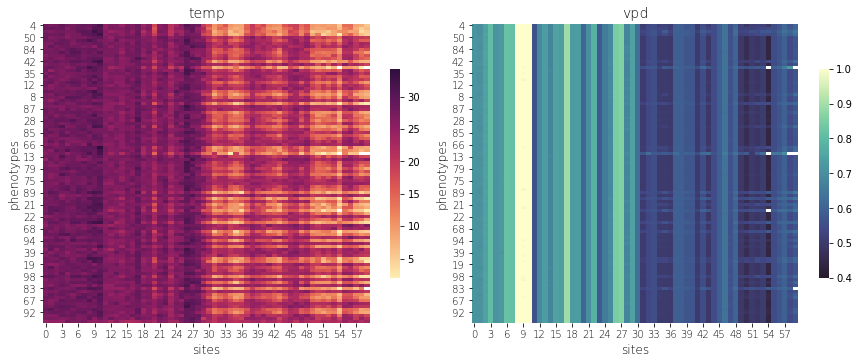

In [166]:
mx_temp = agg_sims(df_matured, groups, 'mean', 'temp_air')
df_temp = pd.DataFrame(mx_temp)
mx_vpd = agg_sims(df_matured, groups, 'mean', 'vpd')
df_vpd = pd.DataFrame(mx_vpd)

fig = plt.figure(figsize=(15,5.5))
ax1 = fig.add_subplot(1,2,1)
hm = sns.heatmap(df_temp.reindex(phenos_ranked),
                 cmap=Matter_8.mpl_colormap,
                 cbar_kws={'shrink': 0.7})
ax1.set_title('temp', fontweight='light', size=14)
ax1.set_xlabel('sites', fontweight='light', size=12)
ax1.set_ylabel('phenotypes', fontweight='light', size=12)
plt.xticks(fontweight='light', fontsize=10)
plt.yticks(fontweight='light', fontsize=10, rotation=0)

ax2 = fig.add_subplot(1,2,2)
hm = sns.heatmap(df_vpd.reindex(phenos_ranked),
                 vmin=0.4, vmax=1,
                 cmap=Deep_10.mpl_colormap.reversed(),
                 cbar_kws={'shrink': 0.7})
ax2.set_title('vpd', fontweight='light', size=14)
ax2.set_xlabel('sites', fontweight='light', size=12)
ax2.set_ylabel('phenotypes', fontweight='light', size=12)
plt.xticks(fontweight='light', fontsize=10)
plt.yticks(fontweight='light', fontsize=10, rotation=0)

fig.subplots_adjust(wspace=0.05)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_gseason_climate.png', format='png', dpi=800)

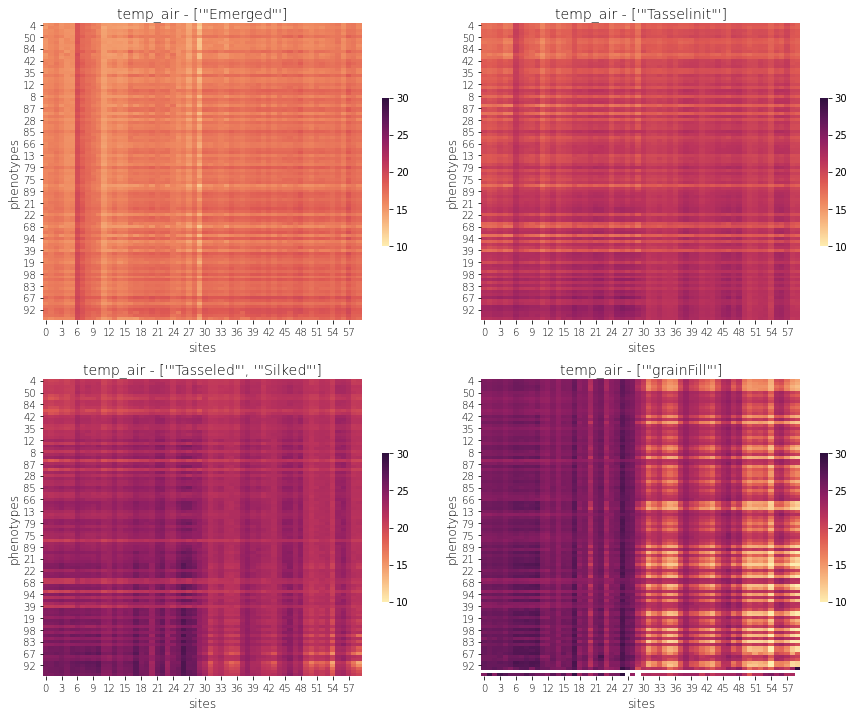

In [8]:
# Parameters
df = df_gseason_climate
sim = 'temp_air'
agg_method = 'mean'
phenostages = [['"Emerged"'], ['"Tasselinit"'], ['"Tasseled"', '"Silked"'], ['"grainFill"']]

# Visualization
fig = plt.figure(figsize=(15,12))

for index in np.arange(4):
    phenostage = phenostages[index]
    mx_sims = process_sims(df, sites, phenos, phenostage, sim, agg_method)
    df_sims = pd.DataFrame(mx_sims).reindex(phenos_ranked)

    ax = fig.add_subplot(2,2,index+1)
    im = sns.heatmap(df_sims, cmap=Matter_8.mpl_colormap,
                     cbar_kws={'shrink': 0.5},
                     vmin=10, vmax=30)
    ax.set_title(f'{sim} - {phenostage}', fontweight='light', size=14)
    ax.set_xlabel('sites', fontweight='light', size=12)
    ax.set_ylabel('phenotypes', fontweight='light', size=12)
    plt.xticks(fontweight='light', fontsize=10)
    plt.yticks(fontweight='light', fontsize=10, rotation=0)

fig.subplots_adjust(wspace=0.1)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_phenostage_temp.png', format='png', dpi=800)

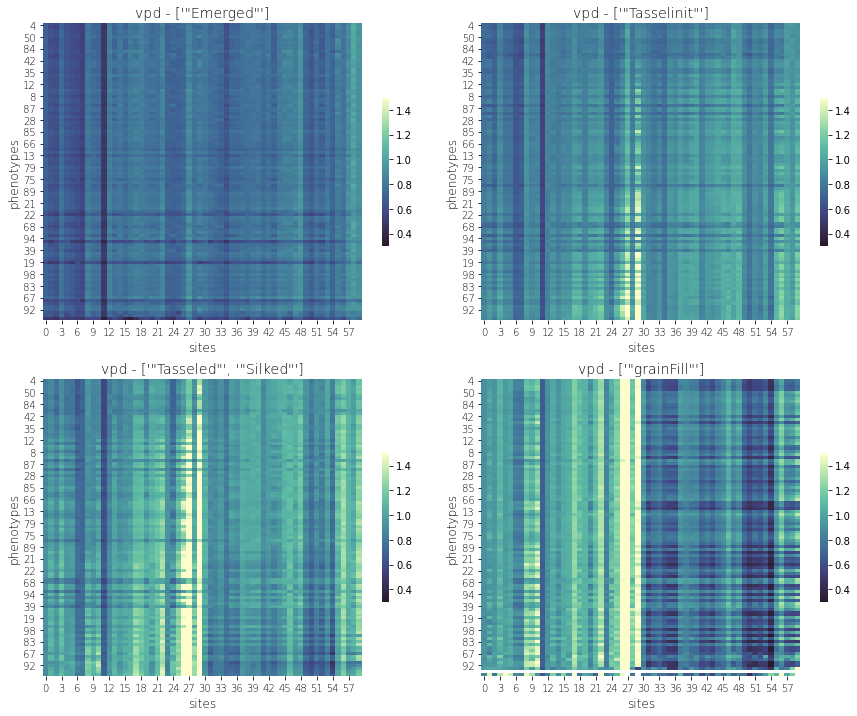

In [173]:
# Parameters
df = df_gseason_climate
sim = 'vpd'
agg_method = 'mean'
phenostages = [['"Emerged"'], ['"Tasselinit"'], ['"Tasseled"', '"Silked"'], ['"grainFill"']]

# Visualization
fig = plt.figure(figsize=(15,12))

for index in np.arange(4):
    phenostage = phenostages[index]
    mx_sims = process_sims(df, sites, phenos, phenostage, sim, agg_method)
    df_sims = pd.DataFrame(mx_sims).reindex(phenos_ranked)

    ax = fig.add_subplot(2,2,index+1)
    im = sns.heatmap(df_sims, cmap=Deep_10.mpl_colormap.reversed(),
                     vmin=0.3, vmax=1.5,
                     cbar_kws={'shrink': 0.5})
    ax.set_title(f'{sim} - {phenostage}', fontweight='light', size=14)
    ax.set_xlabel('sites', fontweight='light', size=12)
    ax.set_ylabel('phenotypes', fontweight='light', size=12)
    plt.xticks(fontweight='light', fontsize=10)
    plt.yticks(fontweight='light', fontsize=10, rotation=0)

fig.subplots_adjust(wspace=0.1)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_phenostage_vpd.png', format='png', dpi=800)

## 1. Biomass

#### Total biomass

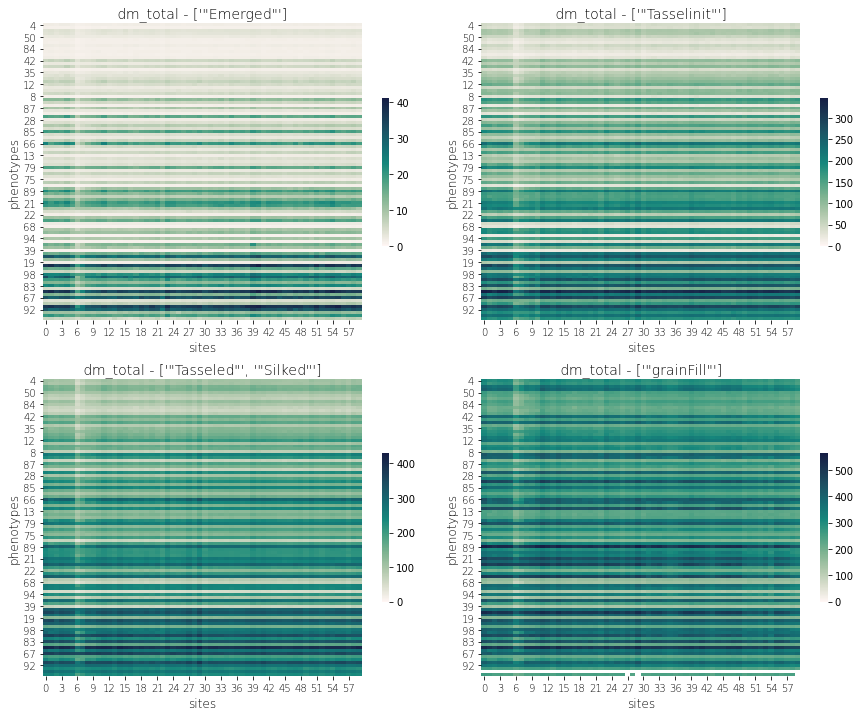

In [228]:
# Parameters
df = df_mass
sim = 'dm_total'
agg_method = 'mean'
phenostages = [['"Emerged"'], ['"Tasselinit"'], ['"Tasseled"', '"Silked"'], ['"grainFill"']]

# Visualization
fig = plt.figure(figsize=(15,12))

for index in np.arange(4):
    phenostage = phenostages[index]
    mx_sims = process_sims(df, sites, phenos, phenostage, sim, agg_method)
    df_sims = pd.DataFrame(mx_sims).reindex(phenos_ranked)

    ax = fig.add_subplot(2,2,index+1)
    im = sns.heatmap(df_sims, cmap = Tempo_10.mpl_colormap,
                     cbar_kws={'shrink': 0.5}, vmin=0)
    ax.set_title(f'{sim} - {phenostage}', fontweight='light', size=14)
    ax.set_xlabel('sites', fontweight='light', size=12)
    ax.set_ylabel('phenotypes', fontweight='light', size=12)
    plt.xticks(fontweight='light', fontsize=10)
    plt.yticks(fontweight='light', fontsize=10, rotation=0)

fig.subplots_adjust(wspace=0.1)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_sims_dm_total.png', format='png', dpi=800)

#### Ear biomass

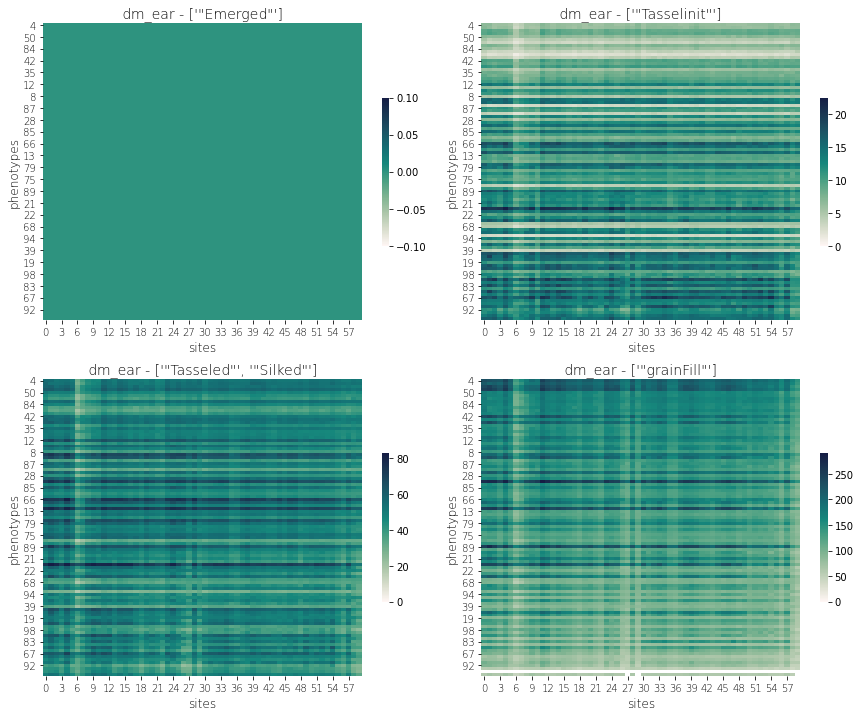

In [227]:
# Parameters
df = df_mass
sim = 'dm_ear'
agg_method = 'mean'
phenostages = [['"Emerged"'], ['"Tasselinit"'], ['"Tasseled"', '"Silked"'], ['"grainFill"']]

# Visualization
fig = plt.figure(figsize=(15,12))

for index in np.arange(4):
    phenostage = phenostages[index]
    mx_sims = process_sims(df, sites, phenos, phenostage, sim, agg_method)
    df_sims = pd.DataFrame(mx_sims).reindex(phenos_ranked)

    ax = fig.add_subplot(2,2,index+1)
    im = sns.heatmap(df_sims, cmap = Tempo_10.mpl_colormap,
                     cbar_kws={'shrink': 0.5}, vmin=0)
    ax.set_title(f'{sim} - {phenostage}', fontweight='light', size=14)
    ax.set_xlabel('sites', fontweight='light', size=12)
    ax.set_ylabel('phenotypes', fontweight='light', size=12)
    plt.xticks(fontweight='light', fontsize=10)
    plt.yticks(fontweight='light', fontsize=10, rotation=0)

fig.subplots_adjust(wspace=0.1)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_sims_dm_ear.png', format='png', dpi=800)

## 2. Physiology

#### Canopy-level net photosynthesis (µmol CO2 per m2 per sec)
- Averaged over daylight hours within each phenostage
- Southern sites actually show higher rates, which probably means that temperatures are not reaching optimal ranges yet
- Site differences don't show until later in the season (grain fill), which is probably because temperature differences between sites were not as pronounced until later in the growing season

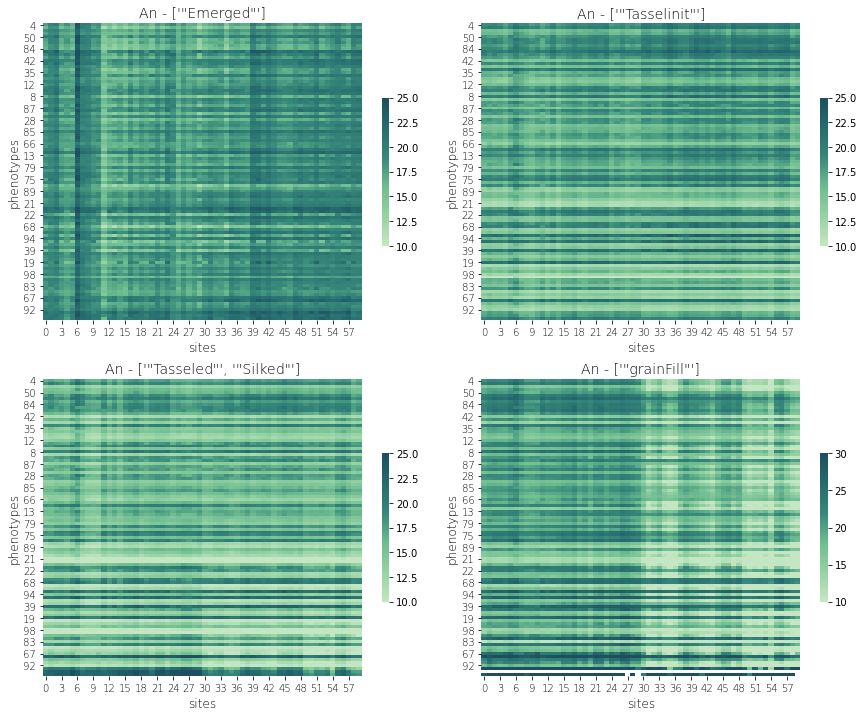

In [13]:
# Parameters
df = df_phys
sim = 'An'
agg_method = 'mean'
phenostages = [['"Emerged"'], ['"Tasselinit"'], ['"Tasseled"', '"Silked"'], ['"grainFill"']]
vmins = [10,10,10,10]
vmaxs = [25,25,25,30]

# Visualization
fig = plt.figure(figsize=(15,12))

for index in np.arange(4):
    phenostage = phenostages[index]
    mx_sims = process_sims(df, sites, phenos, phenostage, sim, agg_method)
    df_sims = pd.DataFrame(mx_sims).reindex(phenos_ranked)

    ax = fig.add_subplot(2,2,index+1)
    im = sns.heatmap(df_sims, cmap = BluGrn_6.mpl_colormap,
                     vmin=vmins[index], vmax=vmaxs[index],
                     cbar_kws={'shrink': 0.5})
    ax.set_title(f'{sim} - {phenostage}', fontweight='light', size=14)
    ax.set_xlabel('sites', fontweight='light', size=12)
    ax.set_ylabel('phenotypes', fontweight='light', size=12)
    plt.xticks(fontweight='light', fontsize=10)
    plt.yticks(fontweight='light', fontsize=10, rotation=0)

fig.subplots_adjust(wspace=0.1)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_sims_an.png', format='png', dpi=800)

#### Sunlit An

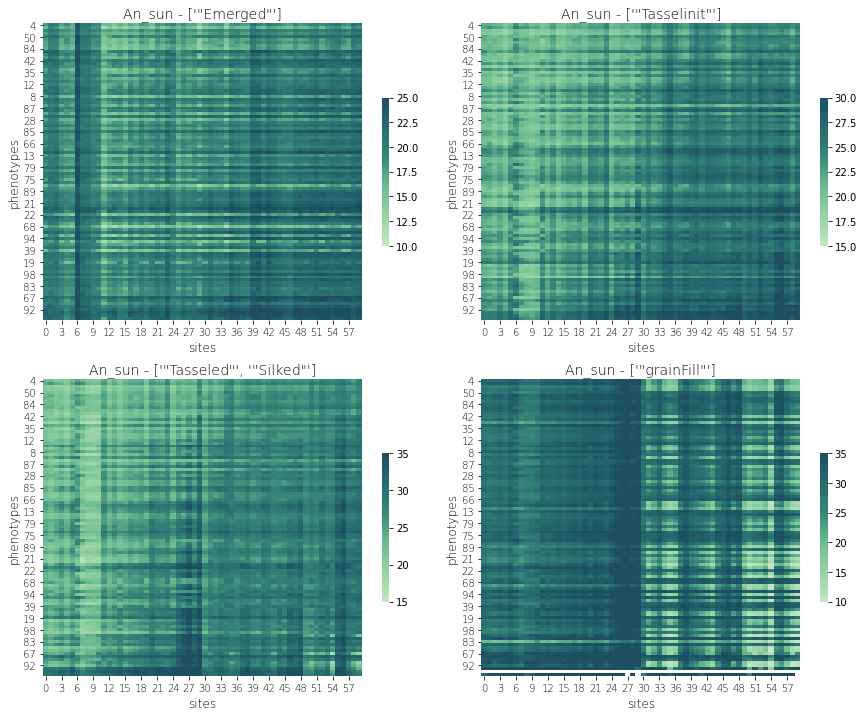

In [16]:
# Parameters
df = df_phys
sim = 'An_sun'
agg_method = 'mean'
phenostages = [['"Emerged"'], ['"Tasselinit"'], ['"Tasseled"', '"Silked"'], ['"grainFill"']]
vmins = [10,15,15,10]
vmaxs = [25,30,35,35]

# Visualization
fig = plt.figure(figsize=(15,12))

for index in np.arange(4):
    phenostage = phenostages[index]
    mx_sims = process_sims(df, sites, phenos, phenostage, sim, agg_method)
    df_sims = pd.DataFrame(mx_sims).reindex(phenos_ranked)

    ax = fig.add_subplot(2,2,index+1)
    im = sns.heatmap(df_sims, cmap = BluGrn_6.mpl_colormap,
                     vmin=vmins[index], vmax=vmaxs[index],
                     cbar_kws={'shrink': 0.5})
    ax.set_title(f'{sim} - {phenostage}', fontweight='light', size=14)
    ax.set_xlabel('sites', fontweight='light', size=12)
    ax.set_ylabel('phenotypes', fontweight='light', size=12)
    plt.xticks(fontweight='light', fontsize=10)
    plt.yticks(fontweight='light', fontsize=10, rotation=0)

fig.subplots_adjust(wspace=0.1)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_sims_an_sun.png', format='png', dpi=800)

#### Shaded An

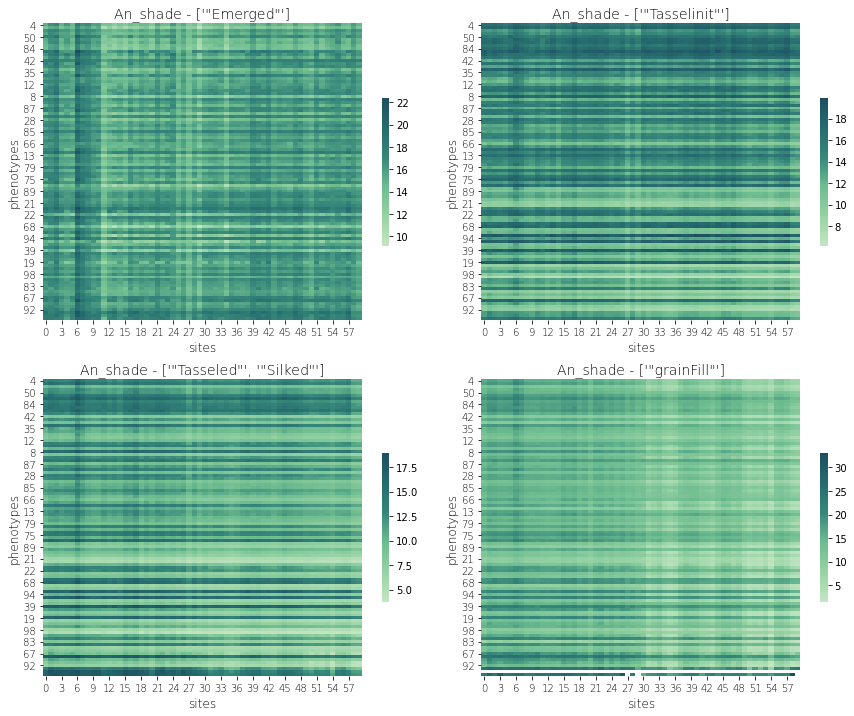

In [11]:
# Parameters
df = df_phys
sim = 'An_shade'
agg_method = 'mean'
phenostages = [['"Emerged"'], ['"Tasselinit"'], ['"Tasseled"', '"Silked"'], ['"grainFill"']]
#vmins = [10,10,10,10]
#vmaxs = [25,25,20,30]

# Visualization
fig = plt.figure(figsize=(15,12))

for index in np.arange(4):
    phenostage = phenostages[index]
    mx_sims = process_sims(df, sites, phenos, phenostage, sim, agg_method)
    df_sims = pd.DataFrame(mx_sims).reindex(phenos_ranked)

    ax = fig.add_subplot(2,2,index+1)
    im = sns.heatmap(df_sims, cmap = BluGrn_6.mpl_colormap,
#                     vmin=vmins[index], vmax=vmaxs[index],
                     cbar_kws={'shrink': 0.5})
    ax.set_title(f'{sim} - {phenostage}', fontweight='light', size=14)
    ax.set_xlabel('sites', fontweight='light', size=12)
    ax.set_ylabel('phenotypes', fontweight='light', size=12)
    plt.xticks(fontweight='light', fontsize=10)
    plt.yticks(fontweight='light', fontsize=10, rotation=0)

fig.subplots_adjust(wspace=0.1)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_sims_an_shade.png', format='png', dpi=800)

#### Net photosynthesis (g per plant per hour)
Averaged over daylight hours within each phenostage

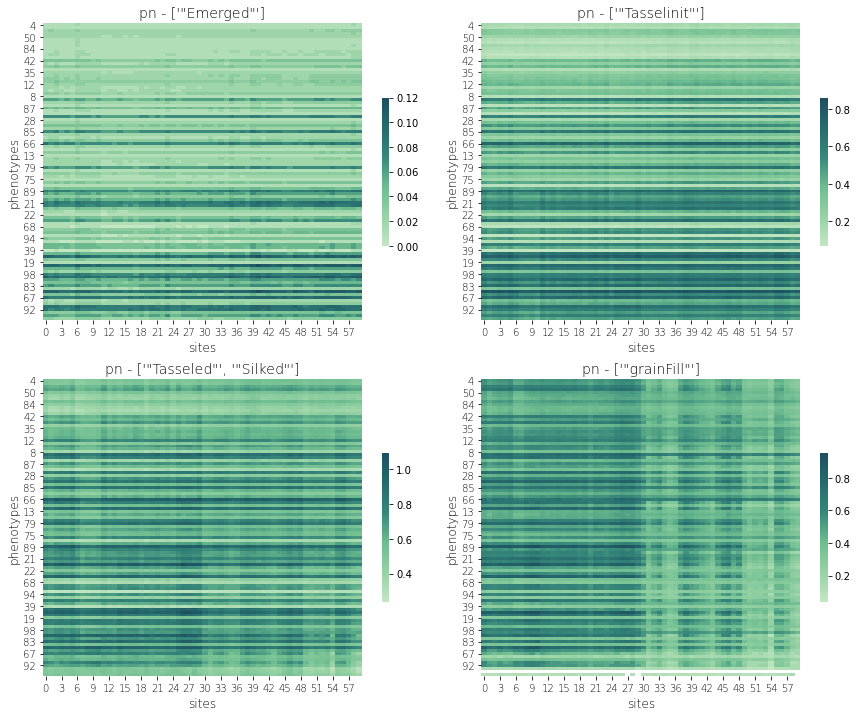

In [7]:
# Parameters
df = df_phys
sim = 'pn'
agg_method = 'mean'
phenostages = [['"Emerged"'], ['"Tasselinit"'], ['"Tasseled"', '"Silked"'], ['"grainFill"']]

# Visualization
fig = plt.figure(figsize=(15,12))

for index in np.arange(4):
    phenostage = phenostages[index]
    mx_sims = process_sims(df, sites, phenos, phenostage, sim, agg_method)
    df_sims = pd.DataFrame(mx_sims).reindex(phenos_ranked)

    ax = fig.add_subplot(2,2,index+1)
    im = sns.heatmap(df_sims, cmap = BluGrn_6.mpl_colormap,
#                     vmin=0, vmax=1,
                     cbar_kws={'shrink': 0.5})
    ax.set_title(f'{sim} - {phenostage}', fontweight='light', size=14)
    ax.set_xlabel('sites', fontweight='light', size=12)
    ax.set_ylabel('phenotypes', fontweight='light', size=12)
    plt.xticks(fontweight='light', fontsize=10)
    plt.yticks(fontweight='light', fontsize=10, rotation=0)

fig.subplots_adjust(wspace=0.1)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_sims_pn.png', format='png', dpi=800)

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

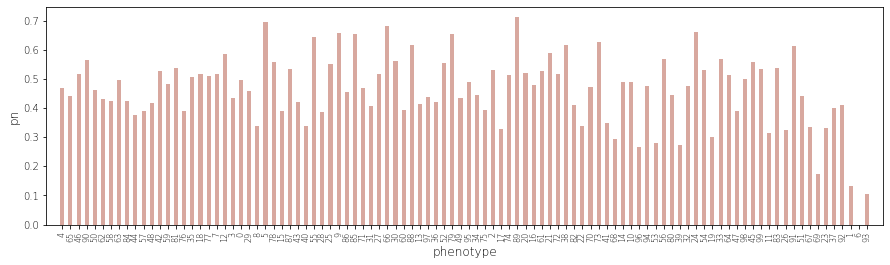

In [19]:
# Parameters
df_phys_grouped = df_phys.groupby(['cvar', 'pheno']).mean().reset_index()

pheno_stage = '"grainFill"'
phys_pns = []
for pheno in phenos_ranked:
    df_bool = df_phys_grouped[
        (df_phys_grouped.pheno == pheno_stage) & 
        (df_phys_grouped.cvar == pheno)].pn.shape[0]
    if df_bool == 0:
        phys_pns.append(np.nan)
    else:
        phys = df_phys_grouped[
            (df_phys_grouped.pheno == pheno_stage) & 
            (df_phys_grouped.cvar == pheno)].pn.values.item()
        phys_pns.append(phys)
        
# Turn top pheno list into string for plotting purposes
phenos_str = [str(pheno) for pheno in phenos_ranked]

# Visualization
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(-2,101)
#ax.set_ylim(0, 0.6)

#ax.bar(phenos_str, pheno_season_len_sorted, width=0.5, color='#d9d9d9')
ax.bar(phenos_str, phys_pns, width=0.5, color=Mendl_4.mpl_colors[2], alpha=0.8)

ax.set_ylabel('pn', fontweight='light', size=12)
ax.set_xlabel('phenotype', fontweight='light', size=12)
plt.xticks(fontweight='light', fontsize=8, rotation=90)
plt.yticks(fontweight='light', fontsize=10, rotation=0)

#### Net carbon gain (gC per plant per hour) - summed within phenostage
Notice how north/south site difference in net photosynthetic rate during the grain filling stage went away with summed net carbon gain. <br/>
I think this is mostly due to the difference in phenostage length between phenotypes.

In [ ]:
# Parameters
df = df_carbon
sim = 'pn_sum'
agg_method = 'mean'
phenostages = [['"Emerged"'], ['"Tasselinit"'], ['"Tasseled"', '"Silked"'], ['"grainFill"']]
vmins = [10,50,40,100]
vmaxs = [50,400,100,500]

# Visualization
fig = plt.figure(figsize=(15,12))

for index in np.arange(4):
    phenostage = phenostages[index]
    mx_sims = process_sims(df, sites, phenos, phenostage, sim, agg_method)
    df_sims = pd.DataFrame(mx_sims).reindex(phenos_ranked)

    ax = fig.add_subplot(2,2,index+1)
    im = sns.heatmap(df_sims, cmap = BluGrn_6.mpl_colormap,
                     vmin=vmins[index], vmax=vmaxs[index],
                     cbar_kws={'shrink': 0.5})
    ax.set_title(f'{sim} - {phenostage}', fontweight='light', size=14)
    ax.set_xlabel('sites', fontweight='light', size=12)
    ax.set_ylabel('phenotypes', fontweight='light', size=12)
    plt.xticks(fontweight='light', fontsize=10)
    plt.yticks(fontweight='light', fontsize=10, rotation=0)

fig.subplots_adjust(wspace=0.1)
#plt.savefig(f'/home/disk/eos8/ach315/upscale/figs/heatmap_sims_pn_sum.png', format='png', dpi=800)

(array([  0., 100., 200., 300., 400., 500., 600.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

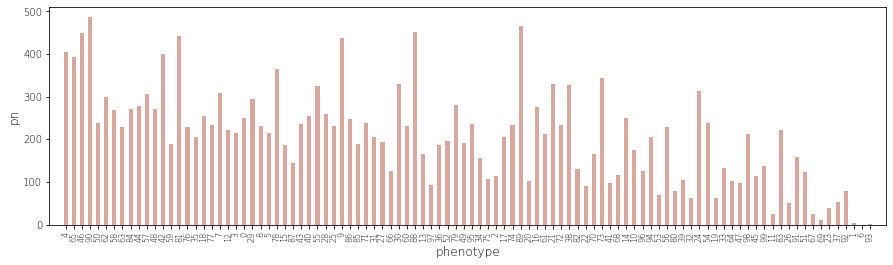

In [20]:
# Parameters
df = df_carbon
df_grouped = df.groupby(['cvar', 'pheno']).mean().reset_index()

pheno_stage = '"grainFill"'
sim_values = []
for pheno in phenos_ranked:
    df_bool = df_grouped[
        (df_grouped.pheno == pheno_stage) & 
        (df_grouped.cvar == pheno)].pn.shape[0]
    if df_bool == 0:
        sim_values.append(np.nan)
    else:
        sim_value = df_grouped[
            (df_grouped.pheno == pheno_stage) & 
            (df_grouped.cvar == pheno)].pn.values.item()
        sim_values.append(sim_value)
        
# Turn top pheno list into string for plotting purposes
phenos_str = [str(pheno) for pheno in phenos_ranked]

# Visualization
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(-2,101)
#ax.set_ylim(0, 0.6)

ax.bar(phenos_str, sim_values, width=0.5, color=Mendl_4.mpl_colors[2], alpha=0.8)

ax.set_ylabel('pn', fontweight='light', size=12)
ax.set_xlabel('phenotype', fontweight='light', size=12)
plt.xticks(fontweight='light', fontsize=8, rotation=90)
plt.yticks(fontweight='light', fontsize=10, rotation=0)

#### Stomatal conductance

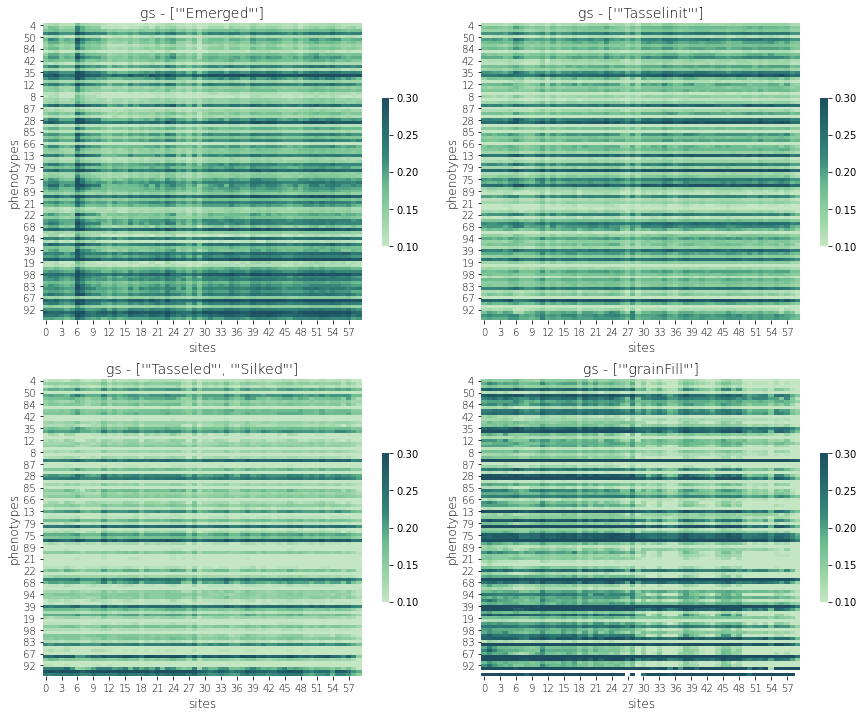

In [9]:
# Parameters
df = df_phys
sim = 'gs'
agg_method = 'mean'
phenostages = [['"Emerged"'], ['"Tasselinit"'], ['"Tasseled"', '"Silked"'], ['"grainFill"']]

# Visualization
fig = plt.figure(figsize=(15,12))

for index in np.arange(4):
    phenostage = phenostages[index]
    mx_sims = process_sims(df, sites, phenos, phenostage, sim, agg_method)
    df_sims = pd.DataFrame(mx_sims).reindex(phenos_ranked)

    ax = fig.add_subplot(2,2,index+1)
    im = sns.heatmap(df_sims, cmap = BluGrn_6.mpl_colormap,
                     vmin=0.1, vmax=0.3,
                     cbar_kws={'shrink': 0.5})
    ax.set_title(f'{sim} - {phenostage}', fontweight='light', size=14)
    ax.set_xlabel('sites', fontweight='light', size=12)
    ax.set_ylabel('phenotypes', fontweight='light', size=12)
    plt.xticks(fontweight='light', fontsize=10)
    plt.yticks(fontweight='light', fontsize=10, rotation=0)

fig.subplots_adjust(wspace=0.1)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_sims_gs.png', format='png', dpi=800)

#### Intrinsic WUE (An/gs)

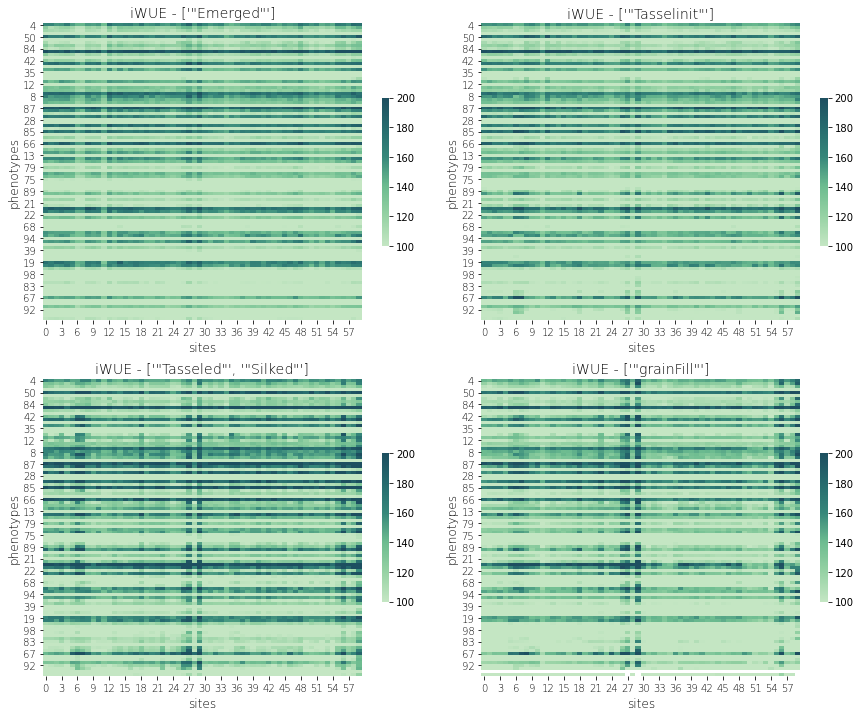

In [52]:
# Parameters
df = df_phys
agg_method = 'mean'
phenostages = [['"Emerged"'], ['"Tasselinit"'], ['"Tasseled"', '"Silked"'], ['"grainFill"']]

# Visualization
fig = plt.figure(figsize=(15,12))

for index in np.arange(4):
    phenostage = phenostages[index]

    # Net photosynthetic rate
    sim = 'An'
    mx_an = process_sims(df, sites, phenos, phenostage, sim, agg_method)   
    # Stomatal conductance
    sim = 'gs'
    mx_gs = process_sims(df, sites, phenos, phenostage, sim, agg_method)
    # Calculate iWUE
    mx_wue = mx_an/mx_gs
    df_wue = pd.DataFrame(mx_wue).reindex(phenos_ranked)

    ax = fig.add_subplot(2,2,index+1)
    im = sns.heatmap(df_wue, cmap = BluGrn_6.mpl_colormap,
                     vmin=100, vmax=200,
                     cbar_kws={'shrink': 0.5})
    ax.set_title(f'iWUE - {phenostage}', fontweight='light', size=14)
    ax.set_xlabel('sites', fontweight='light', size=12)
    ax.set_ylabel('phenotypes', fontweight='light', size=12)
    plt.xticks(fontweight='light', fontsize=10)
    plt.yticks(fontweight='light', fontsize=10, rotation=0)

fig.subplots_adjust(wspace=0.1)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_sims_wue.png', format='png', dpi=800)

## 3. Water

#### Water deficit - noon averaged within phenostage
- ET_demand - ET_supply (g per plant per hour H2O)
- ET_demand basically is transpiration

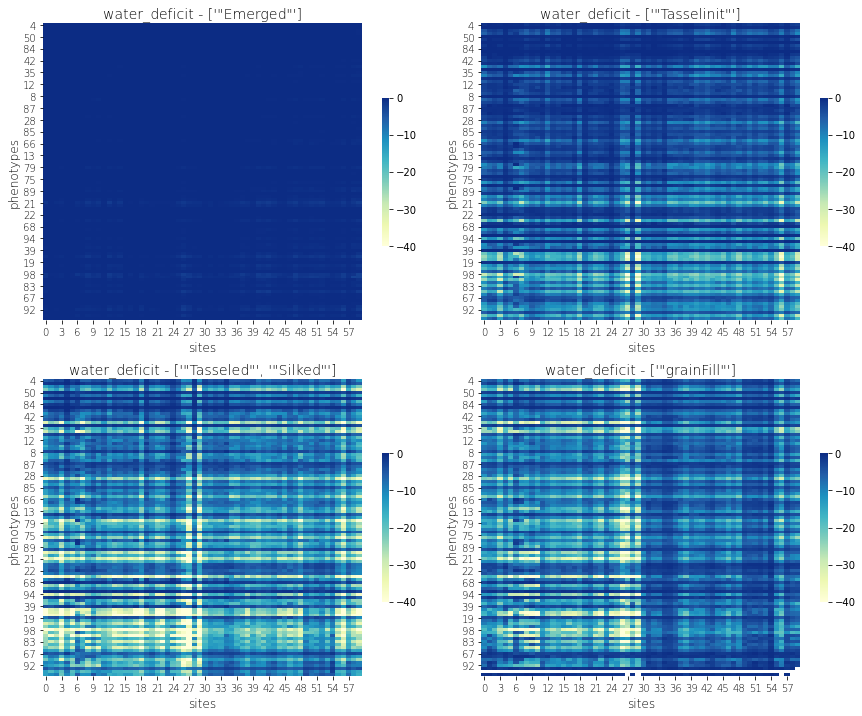

In [10]:
# Parameters
df = df_waterdeficit
sim = 'water_deficit_mean'
agg_method = 'mean'
phenostages = [['"Emerged"'], ['"Tasselinit"'], ['"Tasseled"', '"Silked"'], ['"grainFill"']]

# Visualization
fig = plt.figure(figsize=(15,12))

for index in np.arange(4):
    phenostage = phenostages[index]
    mx_sims = process_sims(df, sites, phenos, phenostage, sim, agg_method)
    df_sims = pd.DataFrame(mx_sims).reindex(phenos_ranked)

    ax = fig.add_subplot(2,2,index+1)
    im = sns.heatmap(df_sims, cmap = YlGnBu_8.mpl_colormap,
                     vmin=-40, vmax=0,
                     cbar_kws={'shrink': 0.5})
    ax.set_title(f'{sim} - {phenostage}', fontweight='light', size=14)
    ax.set_xlabel('sites', fontweight='light', size=12)
    ax.set_ylabel('phenotypes', fontweight='light', size=12)
    plt.xticks(fontweight='light', fontsize=10)
    plt.yticks(fontweight='light', fontsize=10, rotation=0)

fig.subplots_adjust(wspace=0.1)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_sims_wd.png', format='png', dpi=800)

#### Water deficit - summed within phenostage

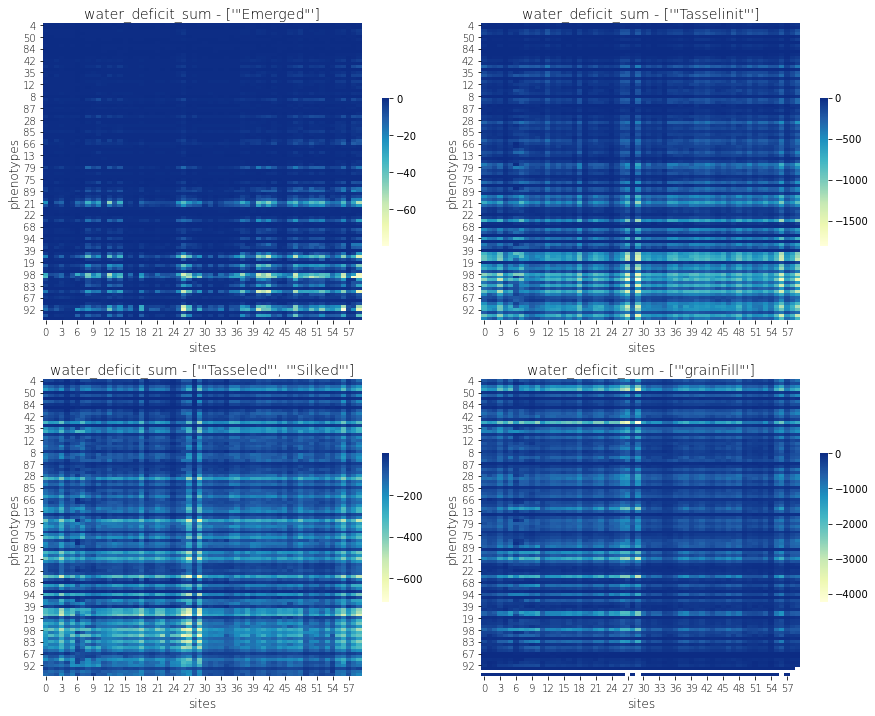

In [185]:
# Parameters
df = df_waterdeficit
sim = 'water_deficit_sum'
agg_method = 'mean'
phenostages = [['"Emerged"'], ['"Tasselinit"'], ['"Tasseled"', '"Silked"'], ['"grainFill"']]

# Visualization
fig = plt.figure(figsize=(15,12))

for index in np.arange(4):
    phenostage = phenostages[index]
    mx_sims = process_sims(df, sites, phenos, phenostage, sim, agg_method)
    df_sims = pd.DataFrame(mx_sims).reindex(phenos_ranked)

    ax = fig.add_subplot(2,2,index+1)
    im = sns.heatmap(df_sims, cmap = YlGnBu_8.mpl_colormap,
#                     vmin=-40, vmax=0,
                     cbar_kws={'shrink': 0.5})
    ax.set_title(f'{sim} - {phenostage}', fontweight='light', size=14)
    ax.set_xlabel('sites', fontweight='light', size=12)
    ax.set_ylabel('phenotypes', fontweight='light', size=12)
    plt.xticks(fontweight='light', fontsize=10)
    plt.yticks(fontweight='light', fontsize=10, rotation=0)

fig.subplots_adjust(wspace=0.1)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_sims_wd.png', format='png', dpi=800)

#### Water deficit per leaf area
Lower performers now end up with lower leaf water deficit per leaf area

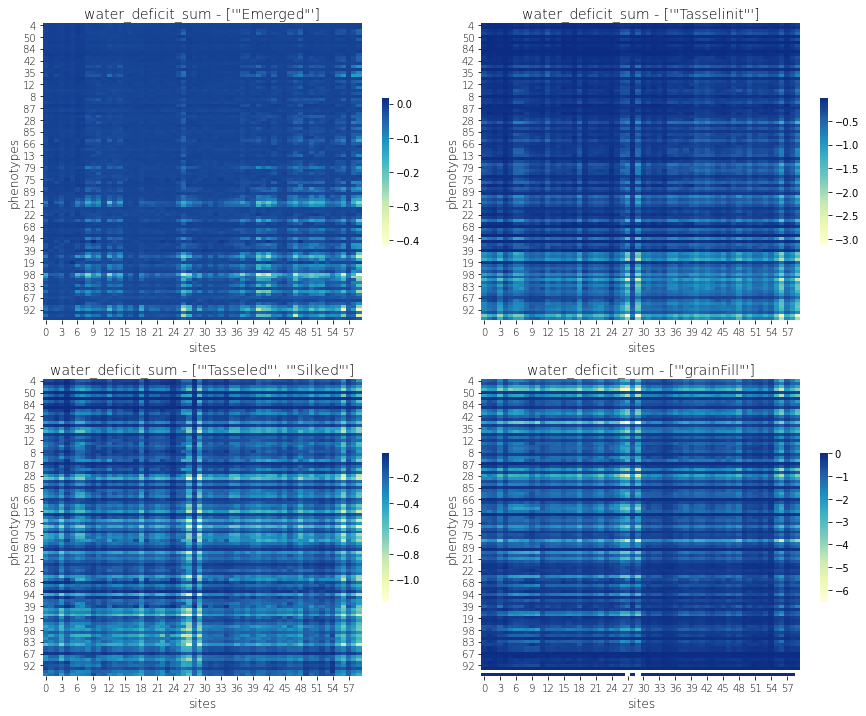

In [211]:
# Parameters
phenostages = [['"Emerged"'], ['"Tasselinit"'], ['"Tasseled"', '"Silked"'], ['"grainFill"']]

# Visualization
fig = plt.figure(figsize=(15,12))

for index in np.arange(4):
    phenostage = phenostages[index]
    mx_sims_wd = process_sims(df_waterdeficit_sum, sites, phenos, phenostage, 'water_deficit_sum', agg_method='mean')
    mx_sims_leaves = process_sims(df_leaves, sites, phenos, phenostage, 'LA', agg_method='max')
    df_sims_wd = pd.DataFrame(mx_sims_wd).reindex(phenos_ranked)
    df_sims_leaves = pd.DataFrame(mx_sims_leaves).reindex(phenos_ranked)
    df_sims = df_sims_wd / df_sims_leaves

    ax = fig.add_subplot(2,2,index+1)
    im = sns.heatmap(df_sims, cmap = YlGnBu_8.mpl_colormap,
                     cbar_kws={'shrink': 0.5})
    ax.set_title(f'{sim} - {phenostage}', fontweight='light', size=14)
    ax.set_xlabel('sites', fontweight='light', size=12)
    ax.set_ylabel('phenotypes', fontweight='light', size=12)
    plt.xticks(fontweight='light', fontsize=10)
    plt.yticks(fontweight='light', fontsize=10, rotation=0)

fig.subplots_adjust(wspace=0.1)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_sims_wd_per_la.png', format='png', dpi=800)

#### Leaf water potential

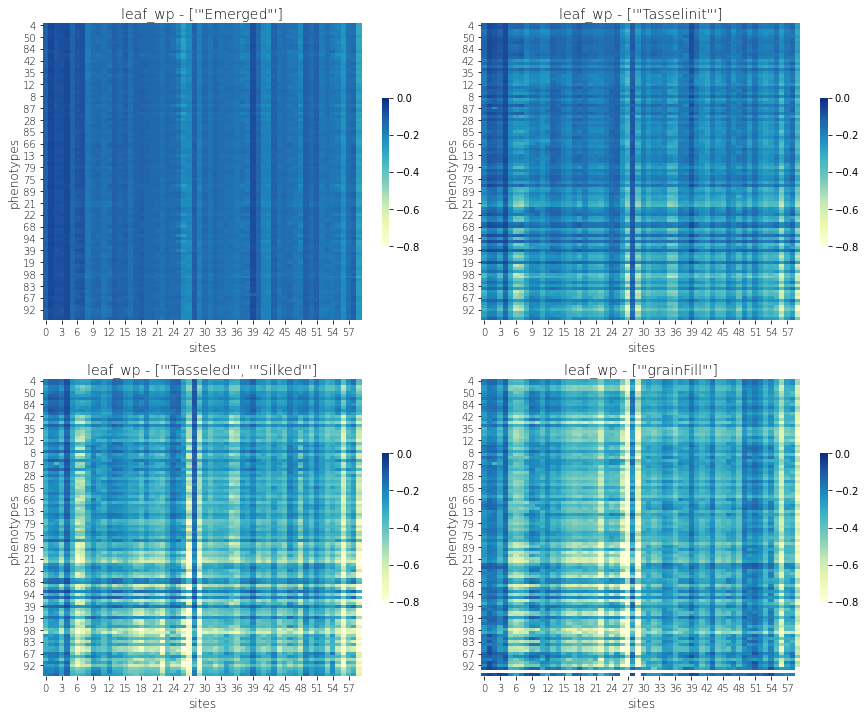

In [11]:
# Parameters
df = df_waterpotential
sim = 'leaf_wp'
agg_method = 'mean'
phenostages = [['"Emerged"'], ['"Tasselinit"'], ['"Tasseled"', '"Silked"'], ['"grainFill"']]

# Visualization
fig = plt.figure(figsize=(15,12))

for index in np.arange(4):
    phenostage = phenostages[index]
    mx_sims = process_sims(df, sites, phenos, phenostage, sim, agg_method)
    df_sims = pd.DataFrame(mx_sims).reindex(phenos_ranked)

    ax = fig.add_subplot(2,2,index+1)
    im = sns.heatmap(df_sims, cmap = YlGnBu_8.mpl_colormap,
                     vmin=-0.8, vmax=0,
                     cbar_kws={'shrink': 0.5})
    ax.set_title(f'{sim} - {phenostage}', fontweight='light', size=14)
    ax.set_xlabel('sites', fontweight='light', size=12)
    ax.set_ylabel('phenotypes', fontweight='light', size=12)
    plt.xticks(fontweight='light', fontsize=10)
    plt.yticks(fontweight='light', fontsize=10, rotation=0)

fig.subplots_adjust(wspace=0.1)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_sims_wp.png', format='png', dpi=800)

## 4. Morphology

#### Total leaf area

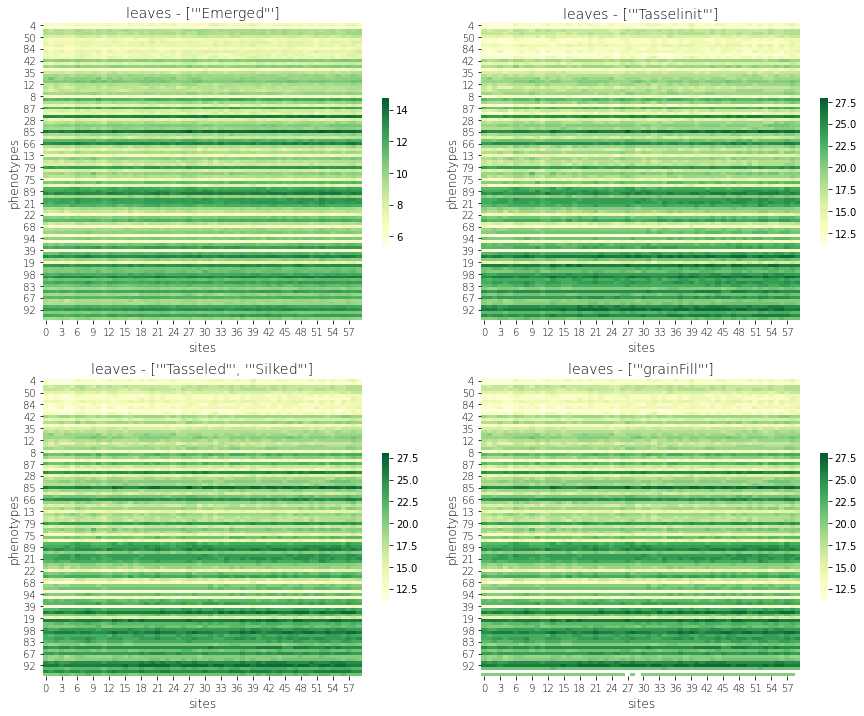

In [43]:
# Parameters
df = df_leaves
sim = 'leaves'
agg_method = 'max'
phenostages = [['"Emerged"'], ['"Tasselinit"'], ['"Tasseled"', '"Silked"'], ['"grainFill"']]

# Visualization
fig = plt.figure(figsize=(15,12))

for index in np.arange(4):
    phenostage = phenostages[index]
    mx_sims = process_sims(df, sites, phenos, phenostage, sim, agg_method)
    df_sims = pd.DataFrame(mx_sims).reindex(phenos_ranked)

    ax = fig.add_subplot(2,2,index+1)
    im = sns.heatmap(df_sims, cmap = YlGn_8.mpl_colormap,
                     cbar_kws={'shrink': 0.5})
    ax.set_title(f'{sim} - {phenostage}', fontweight='light', size=14)
    ax.set_xlabel('sites', fontweight='light', size=12)
    ax.set_ylabel('phenotypes', fontweight='light', size=12)
    plt.xticks(fontweight='light', fontsize=10)
    plt.yticks(fontweight='light', fontsize=10, rotation=0)

fig.subplots_adjust(wspace=0.1)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_sims_leaves.png', format='png', dpi=800)

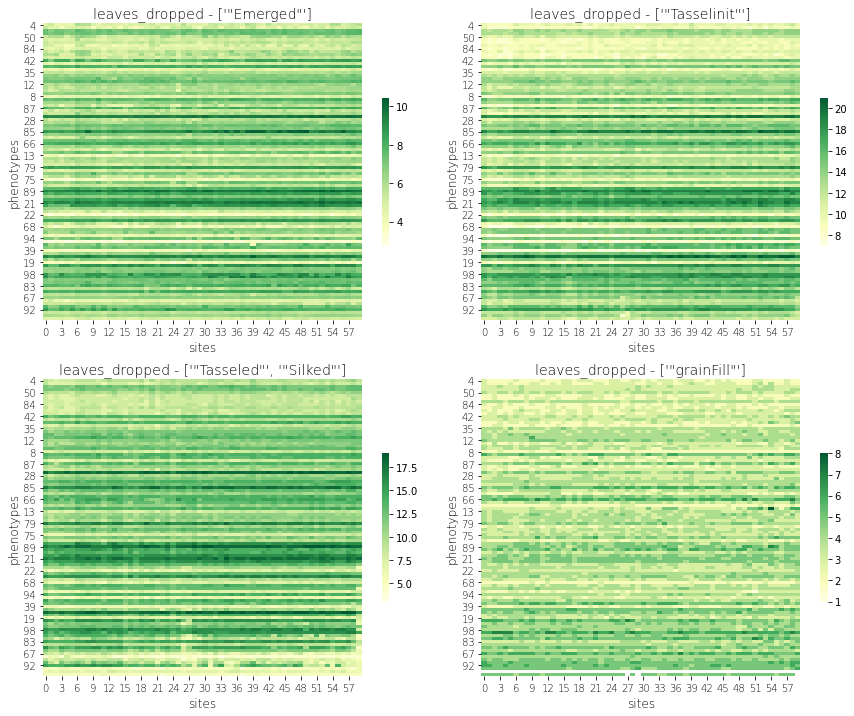

In [48]:
# Parameters
df = df_leaves
sim1 = 'leaves'
sim2 = 'leaves_dropped'

agg_method = 'max'
phenostages = [['"Emerged"'], ['"Tasselinit"'], ['"Tasseled"', '"Silked"'], ['"grainFill"']]

# Visualization
fig = plt.figure(figsize=(15,12))

for index in np.arange(4):
    phenostage = phenostages[index]
    mx_sims1 = process_sims(df, sites, phenos, phenostage, sim1, agg_method)
    mx_sims2 = process_sims(df, sites, phenos, phenostage, sim2, agg_method)
    mx_sims = mx_sims1 - mx_sims2
    df_sims = pd.DataFrame(mx_sims).reindex(phenos_ranked)

    ax = fig.add_subplot(2,2,index+1)
    im = sns.heatmap(df_sims, cmap = YlGn_8.mpl_colormap,
                     cbar_kws={'shrink': 0.5})
    ax.set_title(f'{sim} - {phenostage}', fontweight='light', size=14)
    ax.set_xlabel('sites', fontweight='light', size=12)
    ax.set_ylabel('phenotypes', fontweight='light', size=12)
    plt.xticks(fontweight='light', fontsize=10)
    plt.yticks(fontweight='light', fontsize=10, rotation=0)

fig.subplots_adjust(wspace=0.1)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_sims_leaves.png', format='png', dpi=800)

<AxesSubplot:>

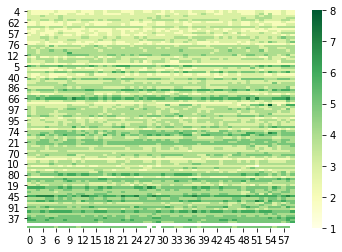

In [52]:
sns.heatmap(df_sims, cmap = YlGn_8.mpl_colormap)

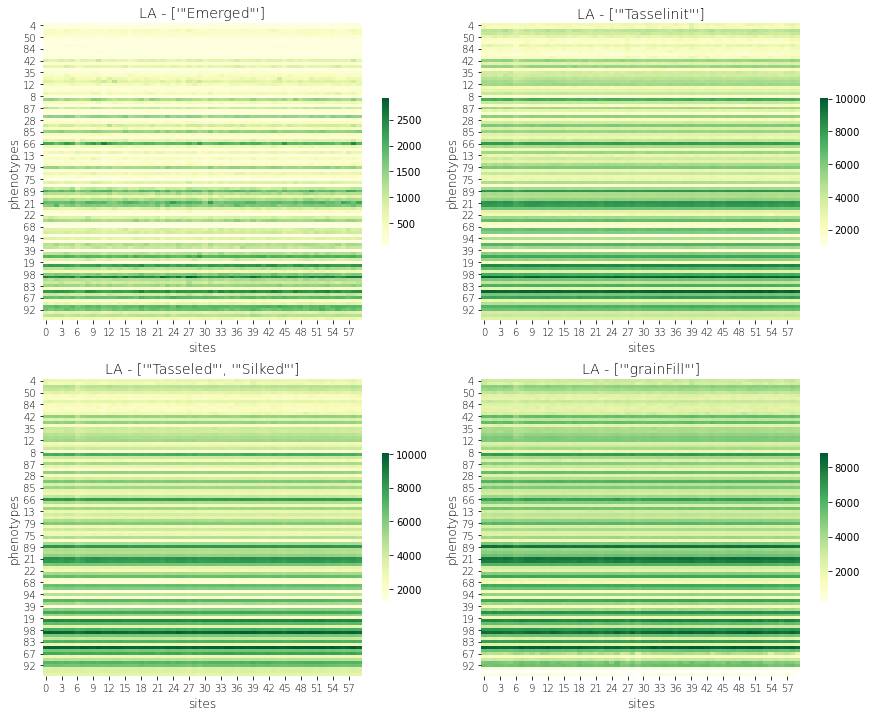

In [12]:
# Parameters
df = df_leaves
sim = 'LA'
agg_method = 'max'
phenostages = [['"Emerged"'], ['"Tasselinit"'], ['"Tasseled"', '"Silked"'], ['"grainFill"']]

# Visualization
fig = plt.figure(figsize=(15,12))

for index in np.arange(4):
    phenostage = phenostages[index]
    mx_sims = process_sims(df, sites, phenos, phenostage, sim, agg_method)
    df_sims = pd.DataFrame(mx_sims).reindex(phenos_ranked)

    ax = fig.add_subplot(2,2,index+1)
    im = sns.heatmap(df_sims, cmap = YlGn_8.mpl_colormap,
                     cbar_kws={'shrink': 0.5})
    ax.set_title(f'{sim} - {phenostage}', fontweight='light', size=14)
    ax.set_xlabel('sites', fontweight='light', size=12)
    ax.set_ylabel('phenotypes', fontweight='light', size=12)
    plt.xticks(fontweight='light', fontsize=10)
    plt.yticks(fontweight='light', fontsize=10, rotation=0)

fig.subplots_adjust(wspace=0.1)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_sims_la.png', format='png', dpi=800)

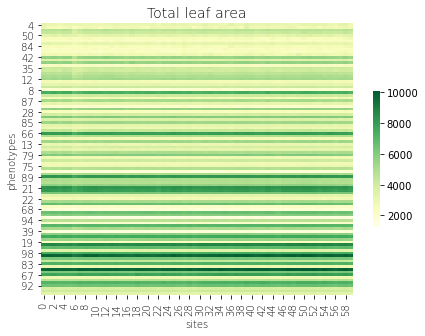

In [61]:
# Parameters
df = df_leaves
sim = 'LA'
agg_method = 'max'
phenostages = 'all'

# Process sim outputs
mx_sims = process_sims(df, sites, phenos, phenostages, sim, agg_method)
df_sims = pd.DataFrame(mx_sims).reindex(phenos_ranked)

# Visualization
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
im = sns.heatmap(df_sims, cmap = YlGn_8.mpl_colormap,
                 cbar_kws={'shrink': 0.5})
ax.set_title('Total leaf area', fontweight='light', size=14)
ax.set_xlabel('sites', fontweight='light')
ax.set_ylabel('phenotypes', fontweight='light')
plt.xticks(fontweight='light', fontsize=10)
plt.yticks(fontweight='light', fontsize=10, rotation=0)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_sims_la_total.png', format='png', dpi=800)

## 5. Phenology

#### Start (jday) of each phenostage

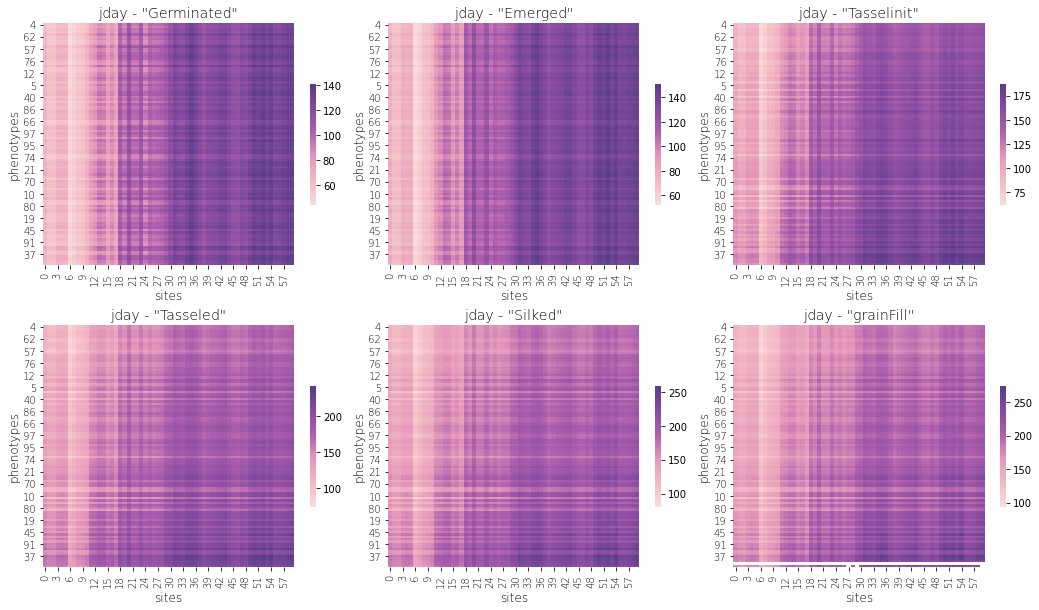

In [23]:
# Parameters
df = df_phenology
sim = 'jday'
agg_method = 'mean'
phenostages = [['"Germinated"'], ['"Emerged"'], ['"Tasselinit"'],
               ['"Tasseled"'], ['"Silked"'], ['"grainFill"']]

# Visualization
fig = plt.figure(figsize=(18,10))

for index in np.arange(6):
    phenostage = phenostages[index]
    mx_sims = process_sims(df, sites, phenos, phenostage, sim, agg_method)
    df_sims = pd.DataFrame(mx_sims).reindex(phenos_ranked)

    ax = fig.add_subplot(2,3,index+1)
    im = sns.heatmap(df_sims, cmap = PurpOr_6.mpl_colormap,
                     cbar_kws={'shrink': 0.5})
    ax.set_title(f'{sim} - {phenostage[0]}', fontweight='light', size=14)
    ax.set_xlabel('sites', fontweight='light', size=12)
    ax.set_ylabel('phenotypes', fontweight='light', size=12)
    plt.xticks(fontweight='light', fontsize=10)
    plt.yticks(fontweight='light', fontsize=10, rotation=0)

fig.subplots_adjust(wspace=0.1)
fig.subplots_adjust(hspace=0.25)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_sims_pheno_jday.png', format='png', dpi=800)

#### Length of each phenostage

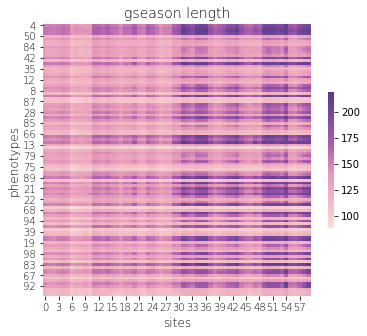

In [221]:
# Parameters
df_phenology_grouped = df_phenology.groupby(['cvar', 'site', 'pheno']).mean()
df_phenology_summed = df_phenology_grouped.groupby(['cvar', 'site']).sum()

# Set up empty matrix to store outputs
mx_phys = np.empty(shape=[len(phenos), len(sites)])
mx_phys[:] = np.nan

# Select outputs
for count_x, pheno in enumerate(phenos):
    for count_y, site in enumerate(sites):
        df_bool = df_phenology_summed.query(
            f'(cvar=={pheno}) & (site=={int(site)})')['pheno_days'].shape[0]
        if df_bool == 0:
            mx_phys[count_x, count_y] = np.nan
        else:
            queried_phys = round(
                df_phenology_summed.query(
                    f'(cvar=={pheno}) '
                    f'& (site=={int(site)})')['pheno_days'].item(), 2)
            mx_phys[count_x, count_y] = queried_phys


df_sims = pd.DataFrame(mx_phys).reindex(phenos_ranked)

# Visualization
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(1,1,1)
im = sns.heatmap(df_sims, cmap = PurpOr_6.mpl_colormap,
                 cbar_kws={'shrink': 0.5})
ax.set_title('gseason length', fontweight='light', size=14)
ax.set_xlabel('sites', fontweight='light', size=12)
ax.set_ylabel('phenotypes', fontweight='light', size=12)
plt.xticks(fontweight='light', fontsize=10)
plt.yticks(fontweight='light', fontsize=10, rotation=0)

fig.subplots_adjust(wspace=0.1)
fig.subplots_adjust(hspace=0.25)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_sims_gseason_len.png', format='png', dpi=800)

<Figure size 432x288 with 0 Axes>

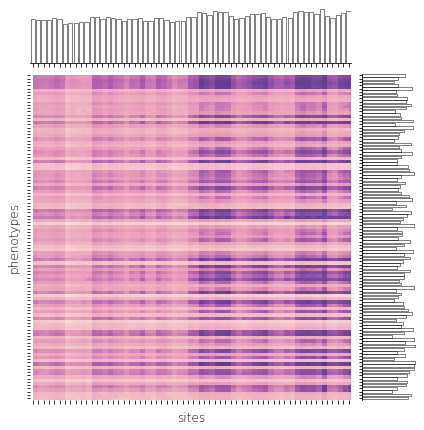

In [36]:
# Parameters
df_phenology_grouped = df_phenology.groupby(['cvar', 'site', 'pheno']).mean()
df_phenology_summed = df_phenology_grouped.groupby(['cvar', 'site']).sum()

# Set up empty matrix to store outputs
mx_phys = np.empty(shape=[len(phenos), len(sites)])
mx_phys[:] = np.nan

# Select outputs
for count_x, pheno in enumerate(phenos):
    for count_y, site in enumerate(sites):
        df_bool = df_phenology_summed.query(
            f'(cvar=={pheno}) & (site=={int(site)})')['pheno_days'].shape[0]
        if df_bool == 0:
            mx_phys[count_x, count_y] = np.nan
        else:
            queried_phys = round(
                df_phenology_summed.query(
                    f'(cvar=={pheno}) '
                    f'& (site=={int(site)})')['pheno_days'].item(), 2)
            mx_phys[count_x, count_y] = queried_phys


df_sims = pd.DataFrame(mx_phys).reindex(phenos_ranked)

# Visualization
fig = plt.figure()

g = sns.JointGrid()
gmain = sns.heatmap(df_sims, cmap = PurpOr_6.mpl_colormap,
                    cbar=False,
                    ax = g.ax_joint)
gmain.set_xlabel('sites', fontweight='light', size=12)
gmain.set_ylabel('phenotypes', fontweight='light', size=12)

gx = sns.barplot(x = np.arange(60), y = pd.DataFrame(mx_phys).mean(axis=0), 
            fill=False, linewidth=0.5, ax=g.ax_marg_x)
gx.set(xlabel=None)
gx.set(xticklabels=[])
gy = sns.barplot(x = pd.DataFrame(mx_phys).mean(axis=1), y = np.arange(100),
                 orient = 'h', fill=False, linewidth=0.5, ax=g.ax_marg_y)
gy.set(xlabel=None)
gy.set(yticklabels=[])

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_sims_gseason_len_jointgrid.png', format='png', dpi=800)

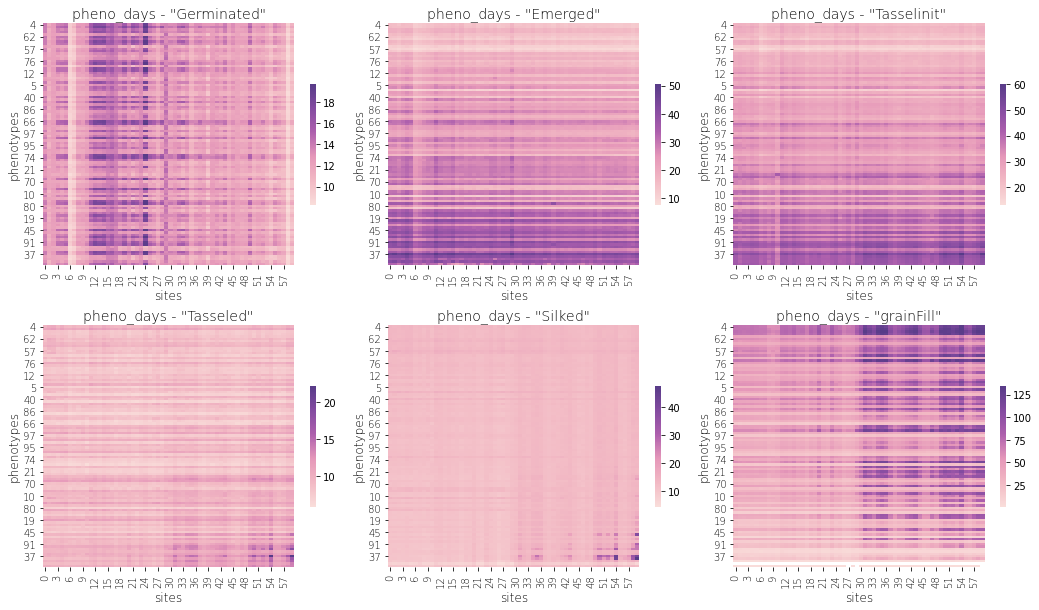

In [59]:
# Parameters
df = df_phenology
sim = 'pheno_days'
agg_method = 'mean'
phenostages = [['"Germinated"'], ['"Emerged"'], ['"Tasselinit"'],
               ['"Tasseled"'], ['"Silked"'], ['"grainFill"']]

# Visualization
fig = plt.figure(figsize=(18,10))

for index in np.arange(6):
    phenostage = phenostages[index]
    mx_sims = process_sims(df, sites, phenos, phenostage, sim, agg_method)
    df_sims = pd.DataFrame(mx_sims).reindex(phenos_ranked)

    ax = fig.add_subplot(2,3,index+1)
    im = sns.heatmap(df_sims, cmap = PurpOr_6.mpl_colormap,
                     cbar_kws={'shrink': 0.5})
    ax.set_title(f'{sim} - {phenostage[0]}', fontweight='light', size=14)
    ax.set_xlabel('sites', fontweight='light', size=12)
    ax.set_ylabel('phenotypes', fontweight='light', size=12)
    plt.xticks(fontweight='light', fontsize=10)
    plt.yticks(fontweight='light', fontsize=10, rotation=0)

fig.subplots_adjust(wspace=0.1)
fig.subplots_adjust(hspace=0.25)
#plt.savefig('/home/disk/eos8/ach315/upscale/figs/heatmap_sims_pheno.png', format='png', dpi=800)

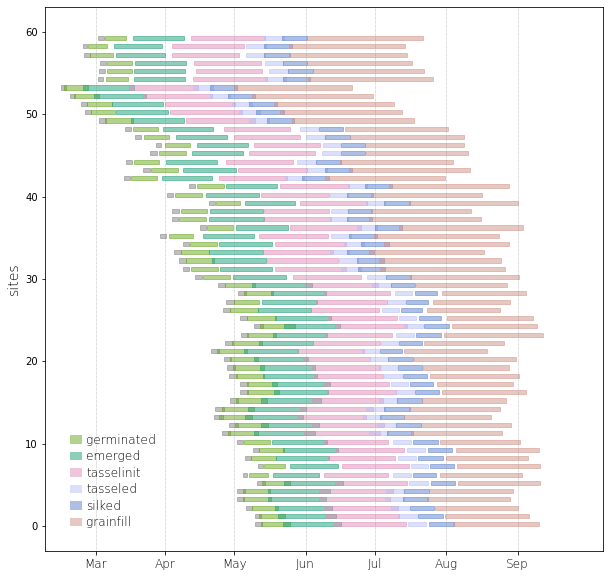

In [23]:

df_phenology_grouped = df_phenology.groupby(['site', 'pheno']).mean()

phenostages = [['"none"', '"Germinated"'],
               ['"Germinated"', '"Emerged"'],
               ['"Emerged"', '"Tasselinit"'],
               ['"Tasselinit"', '"Tasseled"'],
               ['"Tasseled"', '"Silked"'],
               ['"Silked"', '"grainFill"'],
               ['"grainFill"', '"Matured"']]
        
colors = ['grey', '#66a61e', '#1b9e77', 
          Mendl_4.mpl_colors[0],
          Mendl_4.mpl_colors[1],
          Mendl_4.mpl_colors[3],
          Mendl_4.mpl_colors[2]]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.plot([50,270],[0,60], alpha=0)
ax.set_ylabel('sites', fontweight='light', fontsize=14)

jday_months = [61, 91, 121, 152, 182, 213, 244]
ax.set_xticks(jday_months)
ax.set_xticklabels(['Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'],
                   fontweight='light', fontsize=12)

for jday_month in jday_months:
    ax.axvline(x=jday_month, color='grey', linewidth=0.5, linestyle=':')
    

legend_germinated = plt.Rectangle((50, 10), 5, 1, fc='#66a61e', alpha=0.5)
legend_emerged = plt.Rectangle((50, 8), 5, 1, fc='#1b9e77', alpha=0.5)
legend_tasselinit = plt.Rectangle((50, 6), 5, 1, fc=Mendl_4.mpl_colors[0], alpha=0.5)
legend_tasseled = plt.Rectangle((50, 4), 5, 1, fc=Mendl_4.mpl_colors[1], alpha=0.5)
legend_silked = plt.Rectangle((50, 2), 5, 1, fc=Mendl_4.mpl_colors[3], alpha=0.5)
legend_grainfill = plt.Rectangle((50, 0), 5, 1, fc=Mendl_4.mpl_colors[2], alpha=0.5)
plt.gca().add_patch(legend_germinated)
plt.gca().add_patch(legend_emerged)
plt.gca().add_patch(legend_tasselinit)
plt.gca().add_patch(legend_tasseled)
plt.gca().add_patch(legend_silked)
plt.gca().add_patch(legend_grainfill)
ax.text(57, 10, 'germinated', fontweight='light', size=12)
ax.text(57, 8, 'emerged', fontweight='light', size=12)
ax.text(57, 6, 'tasselinit', fontweight='light', size=12)
ax.text(57, 4, 'tasseled', fontweight='light', size=12)
ax.text(57, 2, 'silked', fontweight='light', size=12)
ax.text(57, 0, 'grainfill', fontweight='light', size=12)

for phenostage, color in zip(phenostages, colors):
    df_phenostage1 = df_phenology_grouped[df_phenology_grouped.index.get_level_values('pheno') == f'{phenostage[0]}']
    df_phenostage2 = df_phenology_grouped[df_phenology_grouped.index.get_level_values('pheno') == f'{phenostage[1]}']

    sites1 = list(df_phenostage1.index.get_level_values('site'))
    sites2 = list(df_phenostage2.index.get_level_values('site'))

    jdays_start = pd.DataFrame(np.empty(60), index=sites1, columns=['jday'])
    jdays_start[:] = np.nan
    jdays_start.loc[sites1, 'jday'] = list(df_phenostage1.jday.values)    
    
    jdays_end = pd.DataFrame(np.empty(60), index=sites1, columns=['jday'])
    jdays_end[:] = np.nan
    jdays_end.loc[sites2, 'jday'] = list(df_phenostage2.jday.values)

    jdays_len = [jdays_end.loc[site, 'jday'] - jdays_start.loc[site, 'jday'] for site in sites1]
    rankings = list(np.arange(60))
    rankings.reverse()
    
    for item, site in zip(rankings, sites1):
        rect = patches.Rectangle((jdays_start.loc[site, 'jday'], item), 
                                 jdays_len[item], 0.5,
                                 color=color,
                                 alpha=0.5)
        ax.add_patch(rect)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/bars_phenostage_sites.png', format='png', dpi=800)

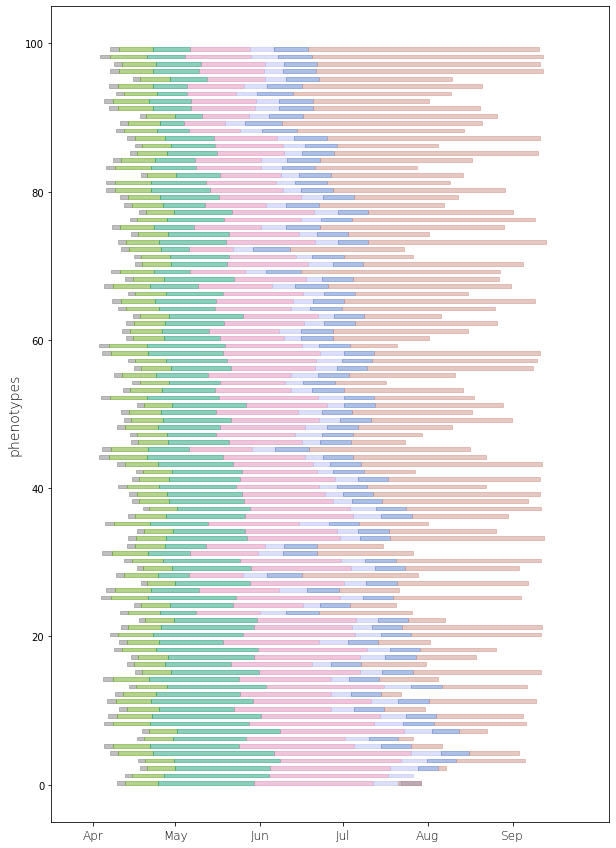

In [214]:
df_phenology_grouped = df_phenology.groupby(['cvar', 'pheno']).mean()

phenostages = [['"none"', '"Germinated"'],
               ['"Germinated"', '"Emerged"'],
               ['"Emerged"', '"Tasselinit"'],
               ['"Tasselinit"', '"Tasseled"'],
               ['"Tasseled"', '"Silked"'],
               ['"Silked"', '"grainFill"'],
               ['"grainFill"', '"Matured"']]
        
colors = ['grey', '#66a61e', '#1b9e77', 
          Mendl_4.mpl_colors[0],
          Mendl_4.mpl_colors[1],
          Mendl_4.mpl_colors[3],
          Mendl_4.mpl_colors[2]]

fig = plt.figure(figsize=(10,15))
ax = fig.add_subplot(1,1,1)
ax.plot([85,270],[0,100], alpha=0)
ax.set_ylabel('phenotypes', fontweight='light', fontsize=14)
ax.set_xticks([91, 121, 152, 182, 213, 244])
ax.set_xticklabels(['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep'], 
                   fontweight='light', fontsize=12)

for phenostage, color in zip(phenostages, colors):
    df_phenostage1 = df_phenology_grouped[df_phenology_grouped.index.get_level_values('pheno') == f'{phenostage[0]}']
    df_phenostage2 = df_phenology_grouped[df_phenology_grouped.index.get_level_values('pheno') == f'{phenostage[1]}']

    cvars1 = list(df_phenostage1.index.get_level_values('cvar'))
    cvars2 = list(df_phenostage2.index.get_level_values('cvar'))

    jdays_start = np.empty(100)
    jdays_start[:] = np.nan
    jdays_start[cvars1] = list(df_phenostage1.jday.values)

    jdays_end = np.empty(100)
    jdays_end[:] = np.nan
    jdays_end[cvars2] = list(df_phenostage2.jday.values)

    jdays_len = [jend - jstart for jend, jstart in zip(jdays_end, jdays_start)]
    rankings = list(np.arange(100))
    rankings.reverse()
    
    for item, pheno in zip(rankings, phenos_ranked):
        rect = patches.Rectangle((jdays_start[pheno], item), 
                                 jdays_len[pheno], 0.5,
                                 color=color,
                                 alpha=0.5)
        ax.add_patch(rect)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/bars_phenostage_phenos.png', format='png', dpi=800)

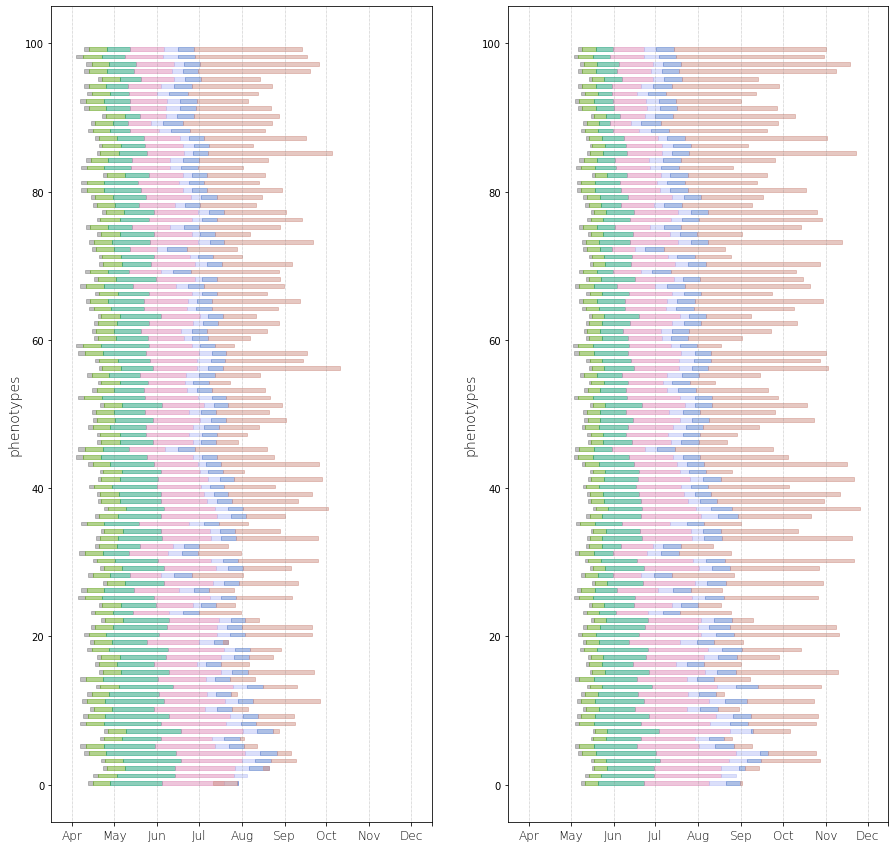

In [237]:
# Split sites into North vs. South
sites_south = sites[:30]
sites_north = sites[30:]

# Process phenostage dataframe
df_phenology_grouped = df_phenology.groupby(['cvar', 'site', 'pheno']).mean()
df_pheno_south = df_phenology_grouped.query(f'site <= {int(sites_south[-1])}')
df_pheno_north = df_phenology_grouped.query(f'site > {int(sites_south[-1])}')

phenostages = [['"none"', '"Germinated"'],
               ['"Germinated"', '"Emerged"'],
               ['"Emerged"', '"Tasselinit"'],
               ['"Tasselinit"', '"Tasseled"'],
               ['"Tasseled"', '"Silked"'],
               ['"Silked"', '"grainFill"'],
               ['"grainFill"', '"Matured"']]

titles = ['South', 'North']
colors = ['grey', '#66a61e', '#1b9e77', 
          Mendl_4.mpl_colors[0],
          Mendl_4.mpl_colors[1],
          Mendl_4.mpl_colors[3],
          Mendl_4.mpl_colors[2]]

fig = plt.figure(figsize=(15,15))

for item, df_loc in enumerate([df_pheno_south, df_pheno_north]):
    ax = fig.add_subplot(1,2,item+1)
    ax.plot([85,270],[0,100], alpha=0)
    ax.set_ylabel('phenotypes', fontweight='light', fontsize=14)
    jday_months = [91, 121, 152, 182, 213, 244, 274, 305, 335, 350]
    ax.set_xticks(jday_months)
    ax.set_xticklabels(['Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', ''], 
                       fontweight='light', fontsize=12)
    for jday_month in jday_months:
        ax.axvline(x=jday_month, color='grey', linewidth=0.5, linestyle=':')
    
    for phenostage, color in zip(phenostages, colors):
        df_phenostage1 = df_loc[df_loc.index.get_level_values('pheno') == f'{phenostage[0]}']
        df_phenostage2 = df_loc[df_loc.index.get_level_values('pheno') == f'{phenostage[1]}']

        cvars1 = list(df_phenostage1.index.get_level_values('cvar'))
        cvars2 = list(df_phenostage2.index.get_level_values('cvar'))

        jdays_start = np.empty(100)
        jdays_start[:] = np.nan
        jdays_start[cvars1] = list(df_phenostage1.jday.values)

        jdays_end = np.empty(100)
        jdays_end[:] = np.nan
        jdays_end[cvars2] = list(df_phenostage2.jday.values)

        jdays_len = [jend - jstart for jend, jstart in zip(jdays_end, jdays_start)]
        rankings = list(np.arange(100))
        rankings.reverse()

        for item, pheno in zip(rankings, phenos_ranked):
            rect = patches.Rectangle((jdays_start[pheno], item), 
                                     jdays_len[pheno], 0.5,
                                     color=color,
                                     alpha=0.5)
            ax.add_patch(rect)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/bars_phenostage_phenos_ns.png', format='png', dpi=800)

#### Grainfill stage compared to total gseason length

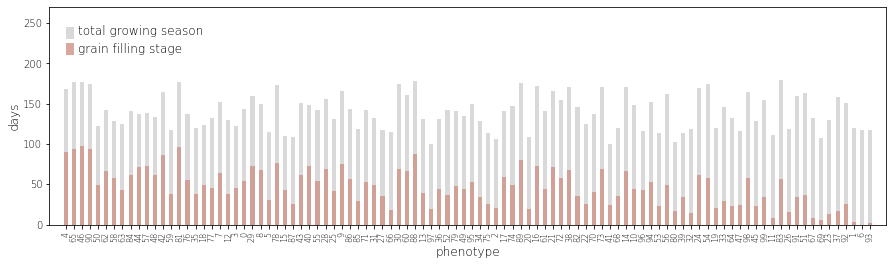

In [18]:
# Group output by phenotypes and pheno stages
df_pheno_grouped = df_phenology.groupby(['cvar', 'pheno']).mean().reset_index()
pheno_season_len = df_pheno_grouped.groupby('cvar').sum().pheno_days
pheno_season_len_sorted = [pheno_season_len[pheno] for pheno in phenos_ranked]

# Fetch pheno stage length of specified stage
pheno_stage = '"grainFill"'
pheno_days = []
for pheno in phenos_ranked:
    df_bool = df_pheno_grouped[
        (df_pheno_grouped.pheno == pheno_stage) & 
        (df_pheno_grouped.cvar == pheno)].pheno_days.shape[0]
    if df_bool == 0:
        pheno_days.append(np.nan)
    else:
        pheno_day = df_pheno_grouped[
            (df_pheno_grouped.pheno == pheno_stage) & 
            (df_pheno_grouped.cvar == pheno)].pheno_days.values.item()
        pheno_days.append(pheno_day)

# Turn top pheno list into string for plotting purposes
phenos_str = [str(pheno) for pheno in phenos_ranked]

# Visualization
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,1,1)

ax.bar(phenos_str, pheno_season_len_sorted, width=0.5, color='#d9d9d9')
ax.bar(phenos_str, pheno_days, width=0.5, color=Mendl_4.mpl_colors[2], alpha=0.8)

ax.set_ylabel('days', fontweight='light', size=12)
ax.set_xlabel('phenotype', fontweight='light', size=12)
plt.xticks(fontweight='light', fontsize=8, rotation=90)
plt.yticks(fontweight='light', fontsize=10, rotation=0)

ax.set_xlim(-2,101)
ax.set_ylim(0, 270)
season_len_legend = plt.Rectangle((0, 230), 1, 15, fc='#d9d9d9')
grainfill_legend = plt.Rectangle((0, 210), 1, 15, fc=Mendl_4.mpl_colors[2], alpha=0.8)
plt.gca().add_patch(season_len_legend)
plt.gca().add_patch(grainfill_legend)
ax.text(1.5, 235, 'total growing season', fontweight='light', size=12)
ax.text(1.5, 213, 'grain filling stage', fontweight='light', size=12)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/bars_sims_grainfill.png', format='png', dpi=800)

#### Tasselinit fraction / total growing season

(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

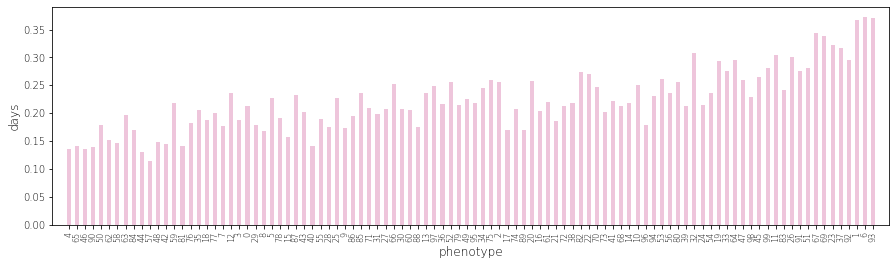

In [48]:
# Group output by phenotypes and pheno stages
df_pheno_grouped = df_phenology.groupby(['cvar', 'pheno']).mean().reset_index()
pheno_season_len = df_pheno_grouped.groupby('cvar').sum().pheno_days
pheno_season_len_sorted = [pheno_season_len[pheno] for pheno in phenos_ranked]

# Fetch pheno stage length of specified stage
#pheno_stage = '"Emerged"'
pheno_stage = '"Tasselinit"'
pheno_days = []
for pheno in phenos_ranked:
    df_bool = df_pheno_grouped[
        (df_pheno_grouped.pheno == pheno_stage) & 
        (df_pheno_grouped.cvar == pheno)].pheno_days.shape[0]
    if df_bool == 0:
        pheno_days.append(np.nan)
    else:
        pheno_day = df_pheno_grouped[
            (df_pheno_grouped.pheno == pheno_stage) & 
            (df_pheno_grouped.cvar == pheno)].pheno_days.values.item()
        pheno_days.append(pheno_day)

# Turn top pheno list into string for plotting purposes
phenos_str = [str(pheno) for pheno in phenos_ranked]

# Visualization
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,1,1)

#ax.bar(phenos_str, pheno_season_len_sorted, width=0.5, color='#d9d9d9')
pheno_frac = [pheno_day/pheno_season_len for pheno_day, pheno_season_len in zip(pheno_days, pheno_season_len_sorted)]
ax.bar(phenos_str, pheno_frac, width=0.5, color=Mendl_4.mpl_colors[0], alpha=0.5)

ax.set_xlim(-2,101)
ax.set_ylabel('days', fontweight='light', size=12)
ax.set_xlabel('phenotype', fontweight='light', size=12)
plt.xticks(fontweight='light', fontsize=8, rotation=90)
plt.yticks(fontweight='light', fontsize=10, rotation=0)

#plt.savefig('/home/disk/eos8/ach315/upscale/figs/bars_sims_tasselinit_frac.png', format='png', dpi=800)

#### grainFill fraction / total growing season

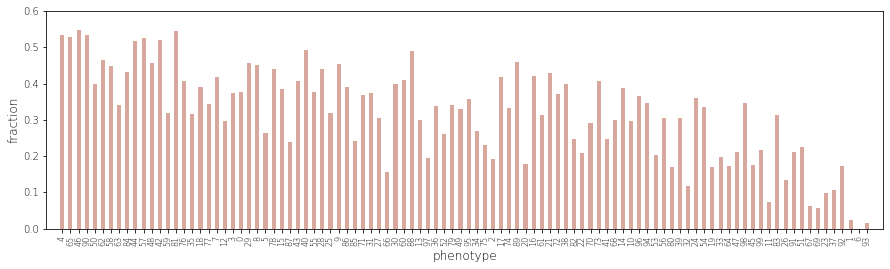

In [11]:
# Group output by phenotypes and pheno stages
df_pheno_grouped = df_phenology.groupby(['cvar', 'pheno']).mean().reset_index()
pheno_season_len = df_pheno_grouped.groupby('cvar').sum().pheno_days
pheno_season_len_sorted = [pheno_season_len[pheno] for pheno in phenos_ranked]

# Fetch pheno stage length of specified stage
pheno_stage = '"grainFill"'
pheno_days = []
for pheno in phenos_ranked:
    df_bool = df_pheno_grouped[
        (df_pheno_grouped.pheno == pheno_stage) & 
        (df_pheno_grouped.cvar == pheno)].pheno_days.shape[0]
    if df_bool == 0:
        pheno_days.append(np.nan)
    else:
        pheno_day = df_pheno_grouped[
            (df_pheno_grouped.pheno == pheno_stage) & 
            (df_pheno_grouped.cvar == pheno)].pheno_days.values.item()
        pheno_days.append(pheno_day)

# Turn top pheno list into string for plotting purposes
phenos_str = [str(pheno) for pheno in phenos_ranked]

# Visualization
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(-2,101)
ax.set_ylim(0, 0.6)

#ax.bar(phenos_str, pheno_season_len_sorted, width=0.5, color='#d9d9d9')
pheno_frac = [pheno_day/pheno_season_len for pheno_day, pheno_season_len in zip(pheno_days, pheno_season_len_sorted)]
ax.bar(phenos_str, pheno_frac, width=0.5, color=Mendl_4.mpl_colors[2], alpha=0.8)

ax.set_ylabel('fraction', fontweight='light', size=12)
ax.set_xlabel('phenotype', fontweight='light', size=12)
plt.xticks(fontweight='light', fontsize=8, rotation=90)
plt.yticks(fontweight='light', fontsize=10, rotation=0)

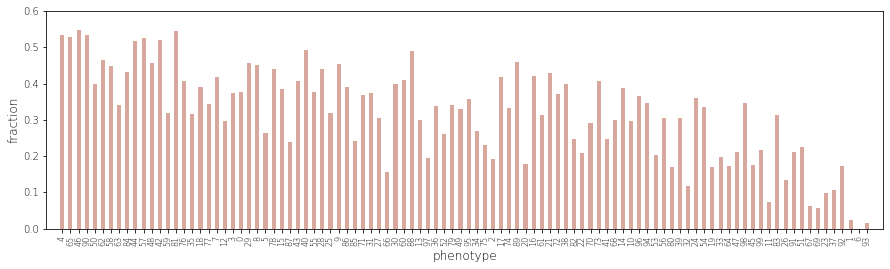

In [9]:
# Group output by phenotypes and pheno stages
df_pheno_grouped = df_phenology.groupby(['cvar', 'pheno']).mean().reset_index()
pheno_season_len = df_pheno_grouped.groupby('cvar').sum().pheno_days
pheno_season_len_sorted = [pheno_season_len[pheno] for pheno in phenos_ranked]

# Fetch pheno stage length of specified stage
pheno_stage = '"grainFill"'
pheno_days = []
for pheno in phenos_ranked:
    df_bool = df_pheno_grouped[
        (df_pheno_grouped.pheno == pheno_stage) & 
        (df_pheno_grouped.cvar == pheno)].pheno_days.shape[0]
    if df_bool == 0:
        pheno_days.append(np.nan)
    else:
        pheno_day = df_pheno_grouped[
            (df_pheno_grouped.pheno == pheno_stage) & 
            (df_pheno_grouped.cvar == pheno)].pheno_days.values.item()
        pheno_days.append(pheno_day)

# Turn top pheno list into string for plotting purposes
phenos_str = [str(pheno) for pheno in phenos_ranked]

# Visualization
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(-2,101)
ax.set_ylim(0, 0.6)

#ax.bar(phenos_str, pheno_season_len_sorted, width=0.5, color='#d9d9d9')
pheno_frac = [pheno_day/pheno_season_len for pheno_day, pheno_season_len in zip(pheno_days, pheno_season_len_sorted)]
ax.bar(phenos_str, pheno_frac, width=0.5, color=Mendl_4.mpl_colors[2], alpha=0.8)

ax.set_ylabel('fraction', fontweight='light', size=12)
ax.set_xlabel('phenotype', fontweight='light', size=12)
plt.xticks(fontweight='light', fontsize=8, rotation=90)
plt.yticks(fontweight='light', fontsize=10, rotation=0)

plt.savefig('/home/disk/eos8/ach315/upscale/figs/bars_sims_grainfill_frac.png', format='png', dpi=800)

In [ ]:
def fetch_phenodays(df_pheno_grouped, phenos_ranked):
    pheno_stage = '"grainFill"'
    pheno_days = []
    for pheno in phenos_ranked:
        df_bool = df_pheno_grouped[
            (df_pheno_grouped.pheno == pheno_stage) & 
            (df_pheno_grouped.cvar == pheno)].pheno_days.shape[0]
        if df_bool == 0:
            pheno_days.append(np.nan)
        else:
            pheno_day = df_pheno_grouped[
                (df_pheno_grouped.pheno == pheno_stage) & 
                (df_pheno_grouped.cvar == pheno)].pheno_days.values.item()
            pheno_days.append(pheno_day)
    
    return(pheno_days)

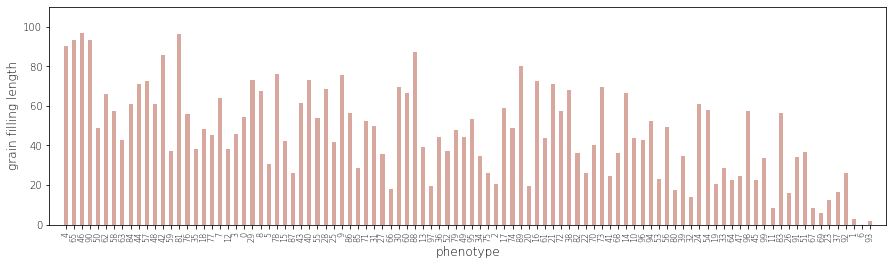

In [39]:
df_phenology_present = pd.read_csv('/home/disk/eos8/ach315/ideotype/ideotype/data/sims/sims_present_pheno.csv')

# Function parameters
n_pheno = 100
w_yield = 1
w_disp = 1
run_name = 'present'

# Rank phenotypes
df_rankings, phenos_ranked = rank_all_phenos(run_name, n_pheno, w_yield, w_disp)

# Group output by phenotypes and pheno stages
df_pheno_grouped_present = df_phenology_present.groupby(['cvar', 'pheno']).mean().reset_index()

# Fetch pheno stage length of specified stage
pheno_days_present = fetch_phenodays(df_pheno_grouped_present, phenos_ranked)

# Turn top pheno list into string for plotting purposes
phenos_str = [str(pheno) for pheno in phenos_ranked]

# Visualization
fig = plt.figure(figsize=(15,4))
ax = fig.add_subplot(1,1,1)
ax.set_xlim(-2,101)
ax.set_ylim(0,110)

ax.bar(phenos_str, pheno_days_present, width=0.5, 
       color=Mendl_4.mpl_colors[2], alpha=0.8)

ax.set_ylabel('grain filling length', fontweight='light', size=12)
ax.set_xlabel('phenotype', fontweight='light', size=12)
plt.xticks(fontweight='light', fontsize=8, rotation=90)
plt.yticks(fontweight='light', fontsize=10, rotation=0)

#plt.savefig(f'/home/disk/eos8/ach315/upscale/figs/bars_sims_grainfill_length_{run_name}.png', format='png', dpi=800)

### Counteracting of photosynthesis & phenology

In [13]:
# photosynthesis
df = df_phys
sim = 'An'
agg_method = 'mean'
phenostage = ['"grainFill"']
mx_an = process_sims(df, sites, phenos, phenostage, sim, agg_method)

df = df_photo_sum
sim = 'pn'
agg_method = 'mean'
phenostage = ['"grainFill"']
mx_pn = process_sims(df, sites, phenos, phenostage, sim, agg_method)

# phenology
df = df_phenology
sim = 'jday'
sim = 'pheno_days'
agg_method = 'mean'
phenostage = ['"grainFill"']
mx_pheno = process_sims(df, sites, phenos, phenostage, sim, agg_method)

# morphology
df = df_leaves
sim = 'LA'
agg_method = 'max'
phenostage = ['"grainFill"']
mx_la = process_sims(df, sites, phenos, phenostage, sims, agg_method)

# temperature
df = df_gseason_climate
sim = 'temp_air'
agg_method = 'mean'
phenostage = ['"grainFill"']
mx_temp = process_sims(df, sites, phenos, phenostage, sim, agg_method)

# vpd
df = df_gseason_climate
sim = 'vpd'
agg_method = 'mean'
phenostage = ['"grainFill"']
mx_vpd = process_sims(df, sites, phenos, phenostage, sim, agg_method)

# water deficit
df = df_waterdeficit
sim = 'water_deficit_sum'
agg_method = 'mean'
phenostage = ['"grainFill"']
mx_wd = process_sims(df, sites, phenos, phenostage, sim, agg_method)

# convert matrix into list
lst_an = mx_an.tolist()
lst_pn = mx_pn.tolist()
lst_la = mx_la.tolist()
lst_pheno = mx_pheno.tolist()
lst_temp = mx_temp.tolist()
lst_vpd = mx_vpd.tolist()
lst_wd = mx_wd.tolist()
lst_flat_an = [x for l in lst_an for x in l]
lst_flat_pn = [x for l in lst_pn for x in l]
lst_flat_la = [x for l in lst_la for x in l]
lst_flat_pheno = [x for l in lst_pheno for x in l]
lst_flat_temp = [x for l in lst_temp for x in l]
lst_flat_vpd = [x for l in lst_vpd for x in l]
lst_flat_wd = [x for l in lst_wd for x in l]

Text(0, 0.5, 'grain fill length')

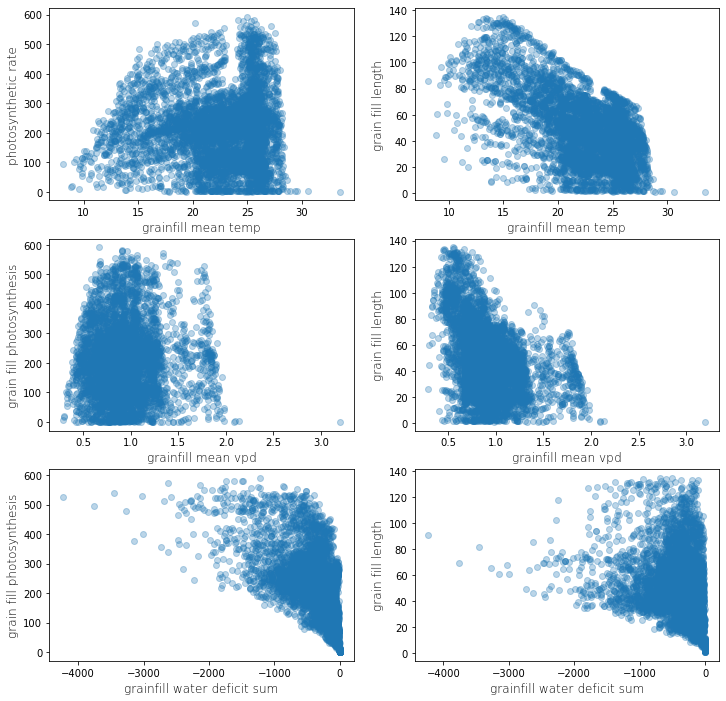

In [75]:
# visualization
fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(3,2,1)
ax1.scatter(lst_flat_temp, lst_flat_pn, alpha=0.3)
ax1.set_xlabel('grainfill mean temp', fontweight='light', fontsize=12)
ax1.set_ylabel('photosynthetic rate', fontweight='light', fontsize=12)

ax2 = fig.add_subplot(3,2,2)
ax2.scatter(lst_flat_temp, lst_flat_pheno, alpha=0.3)
ax2.set_xlabel('grainfill mean temp', fontweight='light', fontsize=12)
ax2.set_ylabel('grain fill length', fontweight='light', fontsize=12)

ax3 = fig.add_subplot(3,2,3)
ax3.scatter(lst_flat_vpd, lst_flat_pn, alpha=0.3)
ax3.set_xlabel('grainfill mean vpd', fontweight='light', fontsize=12)
ax3.set_ylabel('grain fill photosynthesis', fontweight='light', fontsize=12)

ax4 = fig.add_subplot(3,2,4)
ax4.scatter(lst_flat_vpd, lst_flat_pheno, alpha=0.3)
ax4.set_xlabel('grainfill mean vpd', fontweight='light', fontsize=12)
ax4.set_ylabel('grain fill length', fontweight='light', fontsize=12)

ax5 = fig.add_subplot(3,2,5)
ax5.scatter(lst_flat_wd, lst_flat_pn, alpha=0.3)
ax5.set_xlabel('grainfill water deficit sum', fontweight='light', fontsize=12)
ax5.set_ylabel('grain fill photosynthesis', fontweight='light', fontsize=12)

ax6 = fig.add_subplot(3,2,6)
ax6.scatter(lst_flat_wd, lst_flat_pheno, alpha=0.3)
ax6.set_xlabel('grainfill water deficit sum', fontweight='light', fontsize=12)
ax6.set_ylabel('grain fill length', fontweight='light', fontsize=12)

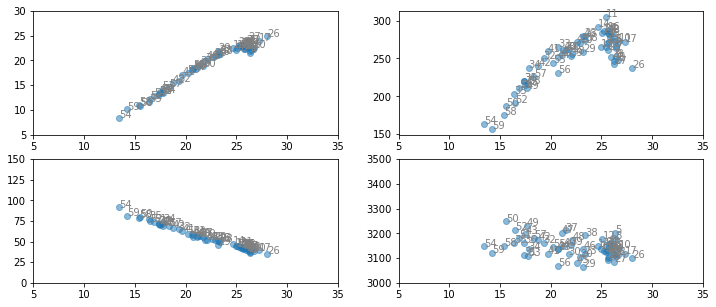

In [78]:
item = 0

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(2,2,1)
ax1.scatter(mx_temp[item], mx_an[item], alpha=0.5)
ax1.set_xlim(5,35)
ax1.set_ylim(5,30)
for site in np.arange(60):
    if (mx_temp[item, site] != np.nan) & (mx_an[item, site] != np.nan):
        ax1.annotate(site, (mx_temp[item, site], mx_an[item, site]), color='grey')

ax2 = fig.add_subplot(2,2,2)
ax2.scatter(mx_temp[item], mx_pn[item], alpha=0.5)
ax2.set_xlim(5,35)
#ax2.set_ylim(0.1,1)
for site in np.arange(60):
    if (mx_temp[item, site] != np.nan) & (mx_pn[item, site] != np.nan):
        ax2.annotate(site, (mx_temp[item, site], mx_pn[item, site]), color='grey')

ax3 = fig.add_subplot(2,2,3)
ax3.scatter(mx_temp[item], mx_pheno[item], alpha=0.5)
ax3.set_xlim(5,35)
ax3.set_ylim(0,150)
for site in np.arange(60):
    if (mx_temp[item, site] != np.nan) & (mx_pheno[item, site] != np.nan):
        ax3.annotate(site, (mx_temp[item, site], mx_pheno[item, site]), color='grey')

ax4 = fig.add_subplot(2,2,4)
ax4.scatter(mx_temp[item], mx_la[item], alpha=0.5)
ax4.set_xlim(5,35)
ax4.set_ylim(3000,3500)
for site in np.arange(60):
    if (mx_temp[item, site] != np.nan) & (mx_la[item, site] != np.nan):
        ax4.annotate(site, (mx_temp[item, site], mx_la[item, site]), color='grey')


(5.0, 35.0)

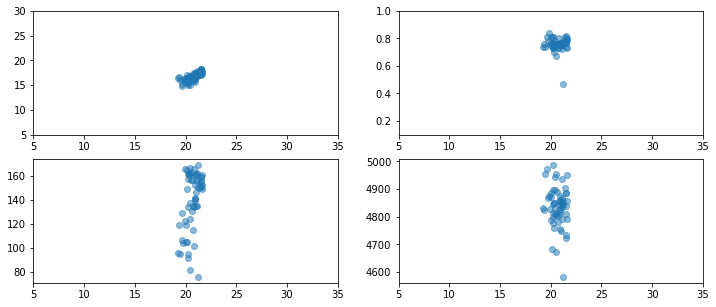

In [57]:
item = 2

fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(2,2,1)
ax1.scatter(mx_tasselinit_temp[item], mx_tasselinit_an[item], alpha=0.5)
ax1.set_xlim(5,35)
ax1.set_ylim(5,30)
#for site in np.arange(60):
#    if (mx_tasselinit_temp[item, site] != np.nan) & (mx_tasselinit_an[item, site] != np.nan):
#        ax1.annotate(site, (mx_tasselinit_temp[item, site], mx_tasselinit_an[item, site]), color='grey')

ax2 = fig.add_subplot(2,2,2)
ax2.scatter(mx_tasselinit_temp[item], mx_tasselinit_pn[item], alpha=0.5)
ax2.set_xlim(5,35)
ax2.set_ylim(0.1,1)
#for site in np.arange(60):
#    if (mx_temp[item, site] != np.nan) & (mx_pn[item, site] != np.nan):
#        ax2.annotate(site, (mx_temp[item, site], mx_pn[item, site]), color='grey')

ax3 = fig.add_subplot(2,2,3)
ax3.scatter(mx_tasselinit_temp[item], mx_tasselinit_pheno[item], alpha=0.5)
ax3.set_xlim(5,35)
#ax3.set_ylim(100,250)
#for site in np.arange(60):
#    if (mx_temp[item, site] != np.nan) & (mx_pheno[item, site] != np.nan):
#        ax3.annotate(site, (mx_temp[item, site], mx_pheno[item, site]), color='grey')

ax4 = fig.add_subplot(2,2,4)
ax4.scatter(mx_tasselinit_temp[item], mx_tasselinit_la[item], alpha=0.5)
ax4.set_xlim(5,35)
#ax4.set_ylim(3000,3500)
#for site in np.arange(60):
#    if (mx_temp[item, site] != np.nan) & (mx_la[item, site] != np.nan):
#        ax4.annotate(site, (mx_temp[item, site], mx_la[item, site]), color='grey')


In [62]:
# photosynthesis
df = df_phys
sim = 'An'
agg_method = 'mean'
phenostage = ['"Tasseled"', '"Silked"']
mx_ts_an = process_sims(df, sites, phenos, phenostage, sim, agg_method)

df = df_photo
sim = 'pn'
agg_method = 'mean'
phenostage = ['"Tasseled"', '"Silked"']
mx_ts_pn = process_sims(df, sites, phenos, phenostage, sim, agg_method)

# phenology
#df = df_phenology
#sim = 'jday'
#agg_method = 'mean'
#phenostage = ['"Tasseled"', '"Silked"']
#mx_ts_pheno = process_sims(df, sites, phenos, phenostage, sim, agg_method)

# morphology
df = df_leaves
sim = 'LA'
agg_method = 'max'
phenostage = ['"Tasseled"', '"Silked"']
mx_ts_la = process_sims(df, sites, phenos, phenostage, sims, agg_method)

# temperature
df = df_gseason_climate
sim = 'temp_air'
agg_method = 'mean'
phenostage = ['"Tasseled"', '"Silked"']
mx_ts_temp = process_sims(df, sites, phenos, phenostage, sim, agg_method)

# vpd
df = df_gseason_climate
sim = 'vpd'
agg_method = 'mean'
phenostage = ['"Tasseled"', '"Silked"']
mx_ts_vpd = process_sims(df, sites, phenos, phenostage, sim, agg_method)

# water deficit
df = df_waterdeficit
sim = 'water_deficit_sum'
agg_method = 'mean'
phenostage = ['"Tasseled"', '"Silked"']
mx_ts_wd = process_sims(df, sites, phenos, phenostage, sim, agg_method)


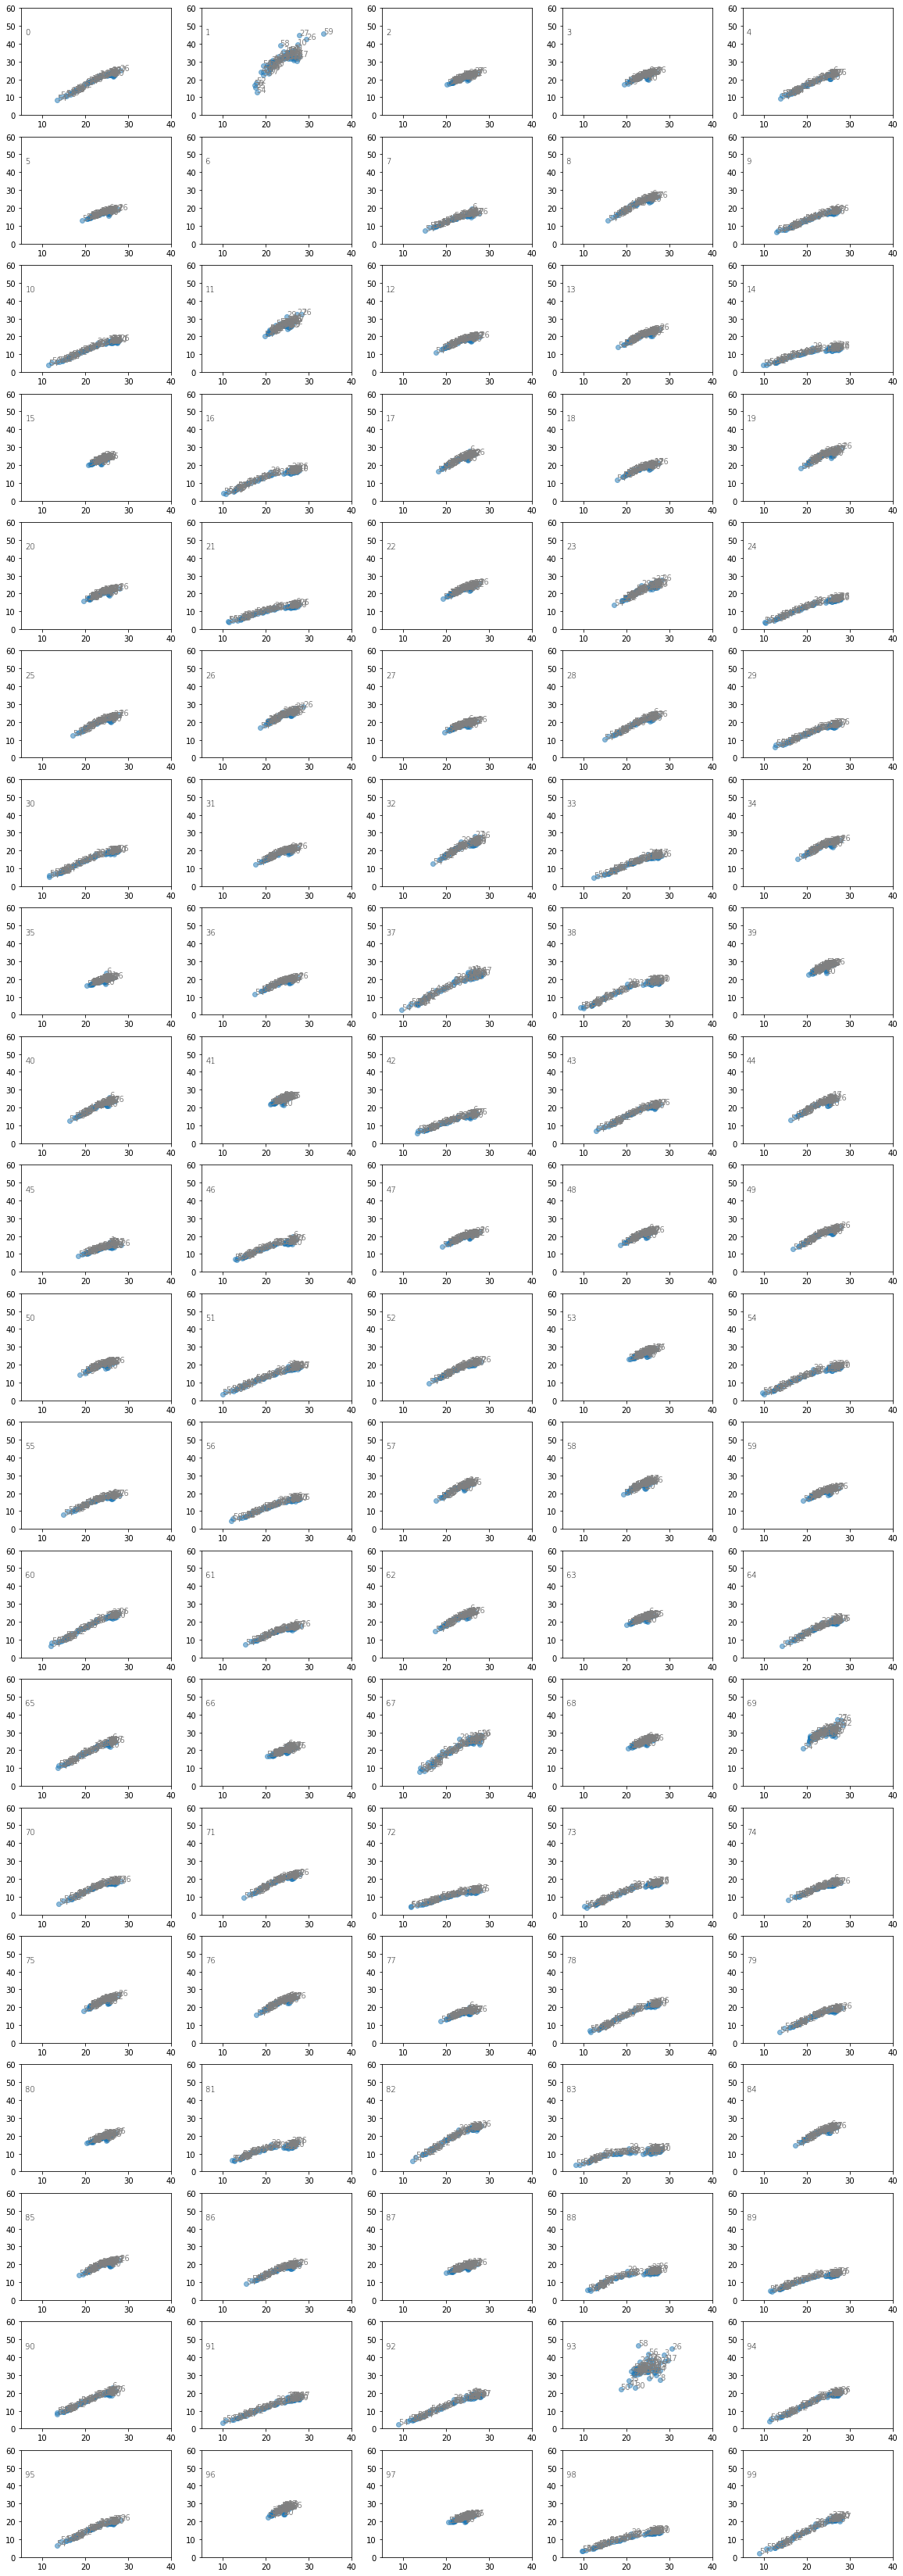

In [22]:
fig = plt.figure(figsize=(20,60))

for item in np.arange(100):
    ax = fig.add_subplot(20,5,item+1)
    ax.scatter(mx_temp[item], mx_an[item], alpha=0.5)
    ax.set_xlim(5,40)
    ax.set_ylim(0,60)
    ax.text(6,45,item, fontweight='light')

    for site in np.arange(60):
        if (mx_temp[item, site] != np.nan) & (mx_an[item, site] != np.nan):
            ax.annotate(site, (mx_temp[item, site], mx_an[item, site]), color='grey')

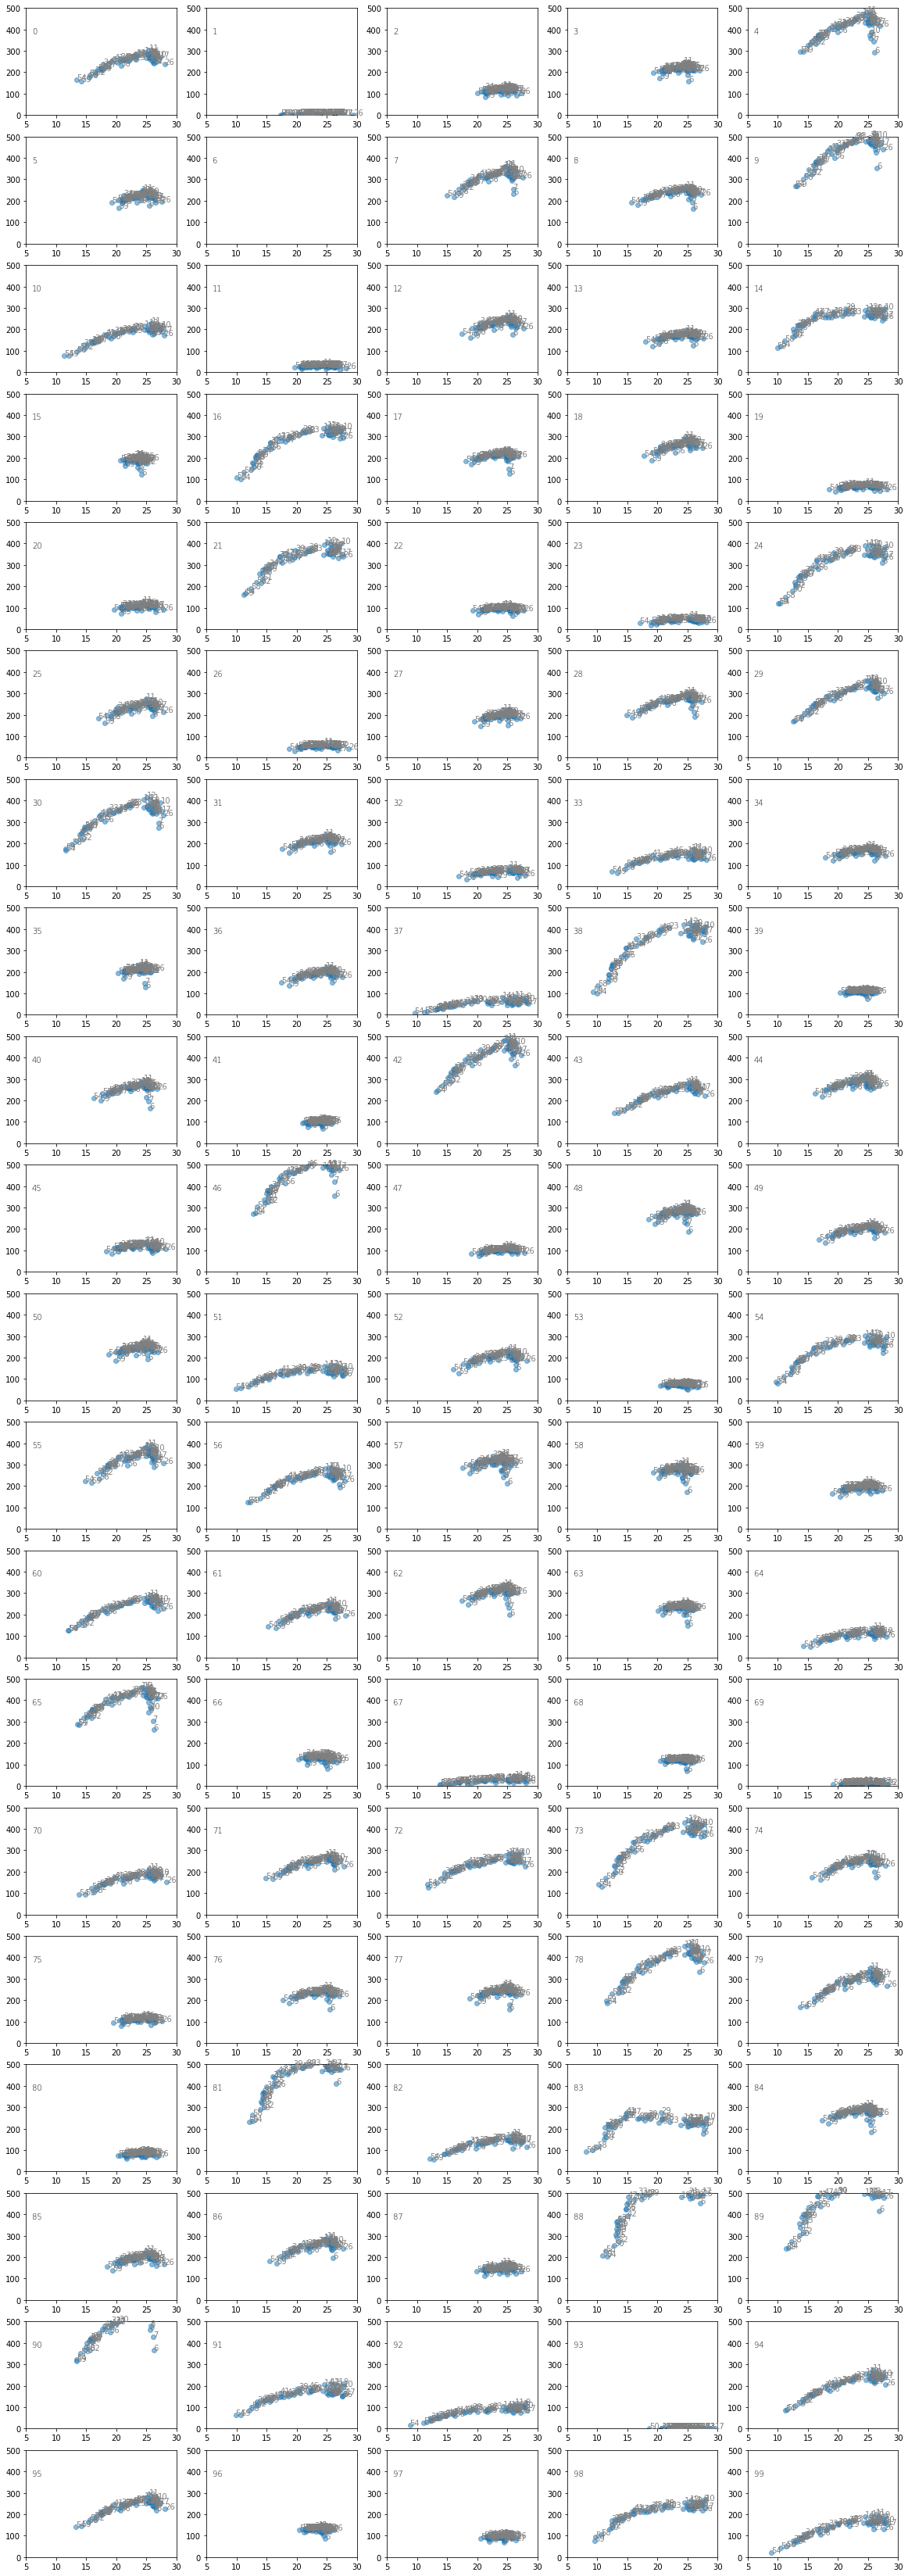

In [158]:
fig = plt.figure(figsize=(20,60))

for item in np.arange(100):
    ax = fig.add_subplot(20,5,item+1)
    ax.scatter(mx_temp[item], mx_pn[item], alpha=0.5)
    ax.set_xlim(5,30)
#    ax.set_title(item)
    ax.set_ylim(0,500)
    ax.text(6,380,item, fontweight='light')

    for site in np.arange(60):
        if (mx_temp[item, site] != np.nan) & (mx_pn[item, site] != np.nan):
            ax.annotate(site, (mx_temp[item, site], mx_pn[item, site]), color='grey')

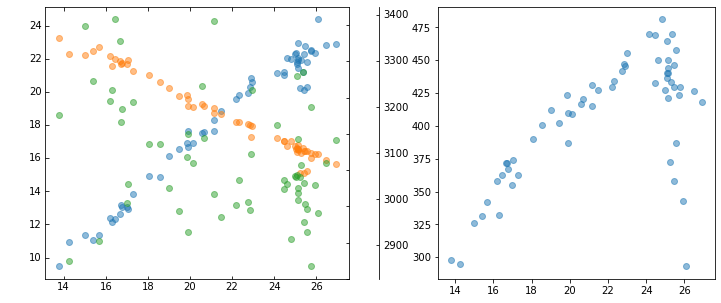

In [156]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
import matplotlib.pyplot as plt

item = 4

fig = plt.figure(figsize=(12,5))
host = host_subplot(1,2,1, axes_class=AA.Axes)

par1 = host.twinx()
par2 = host.twinx()

offset = 30
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right",
                                    axes=par2,
                                    offset=(offset, 0))

par1.set_ylim(0, 150)

p1, = host.plot(mx_temp[item], mx_an[item], 'o', alpha=0.5)
p2, = par1.plot(mx_temp[item], mx_pheno[item], 'o', alpha=0.5)
p3, = par2.plot(mx_temp[item], mx_la[item], 'o', alpha=0.5)

ax2 = fig.add_subplot(1,2,2)
ax2.scatter(mx_temp[item], mx_pn[item], alpha=0.5)

plt.subplots_adjust(left=0.1, wspace=0.5)

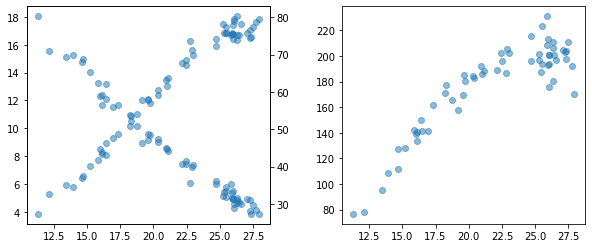

In [117]:
item = 10

fig = plt.figure(figsize=(10,4))
ax1 = fig.add_subplot(1,2,1)
ax1.scatter(mx_temp[item], mx_an[item], alpha=0.5)

ax2 = ax1.twinx()
ax2.scatter(mx_temp[item], mx_pheno[item], alpha=0.5)

ax3 = fig.add_subplot(1,2,2)
ax3.scatter(mx_temp[item], mx_pn[item], alpha=0.5)

fig.subplots_adjust(wspace=0.3)

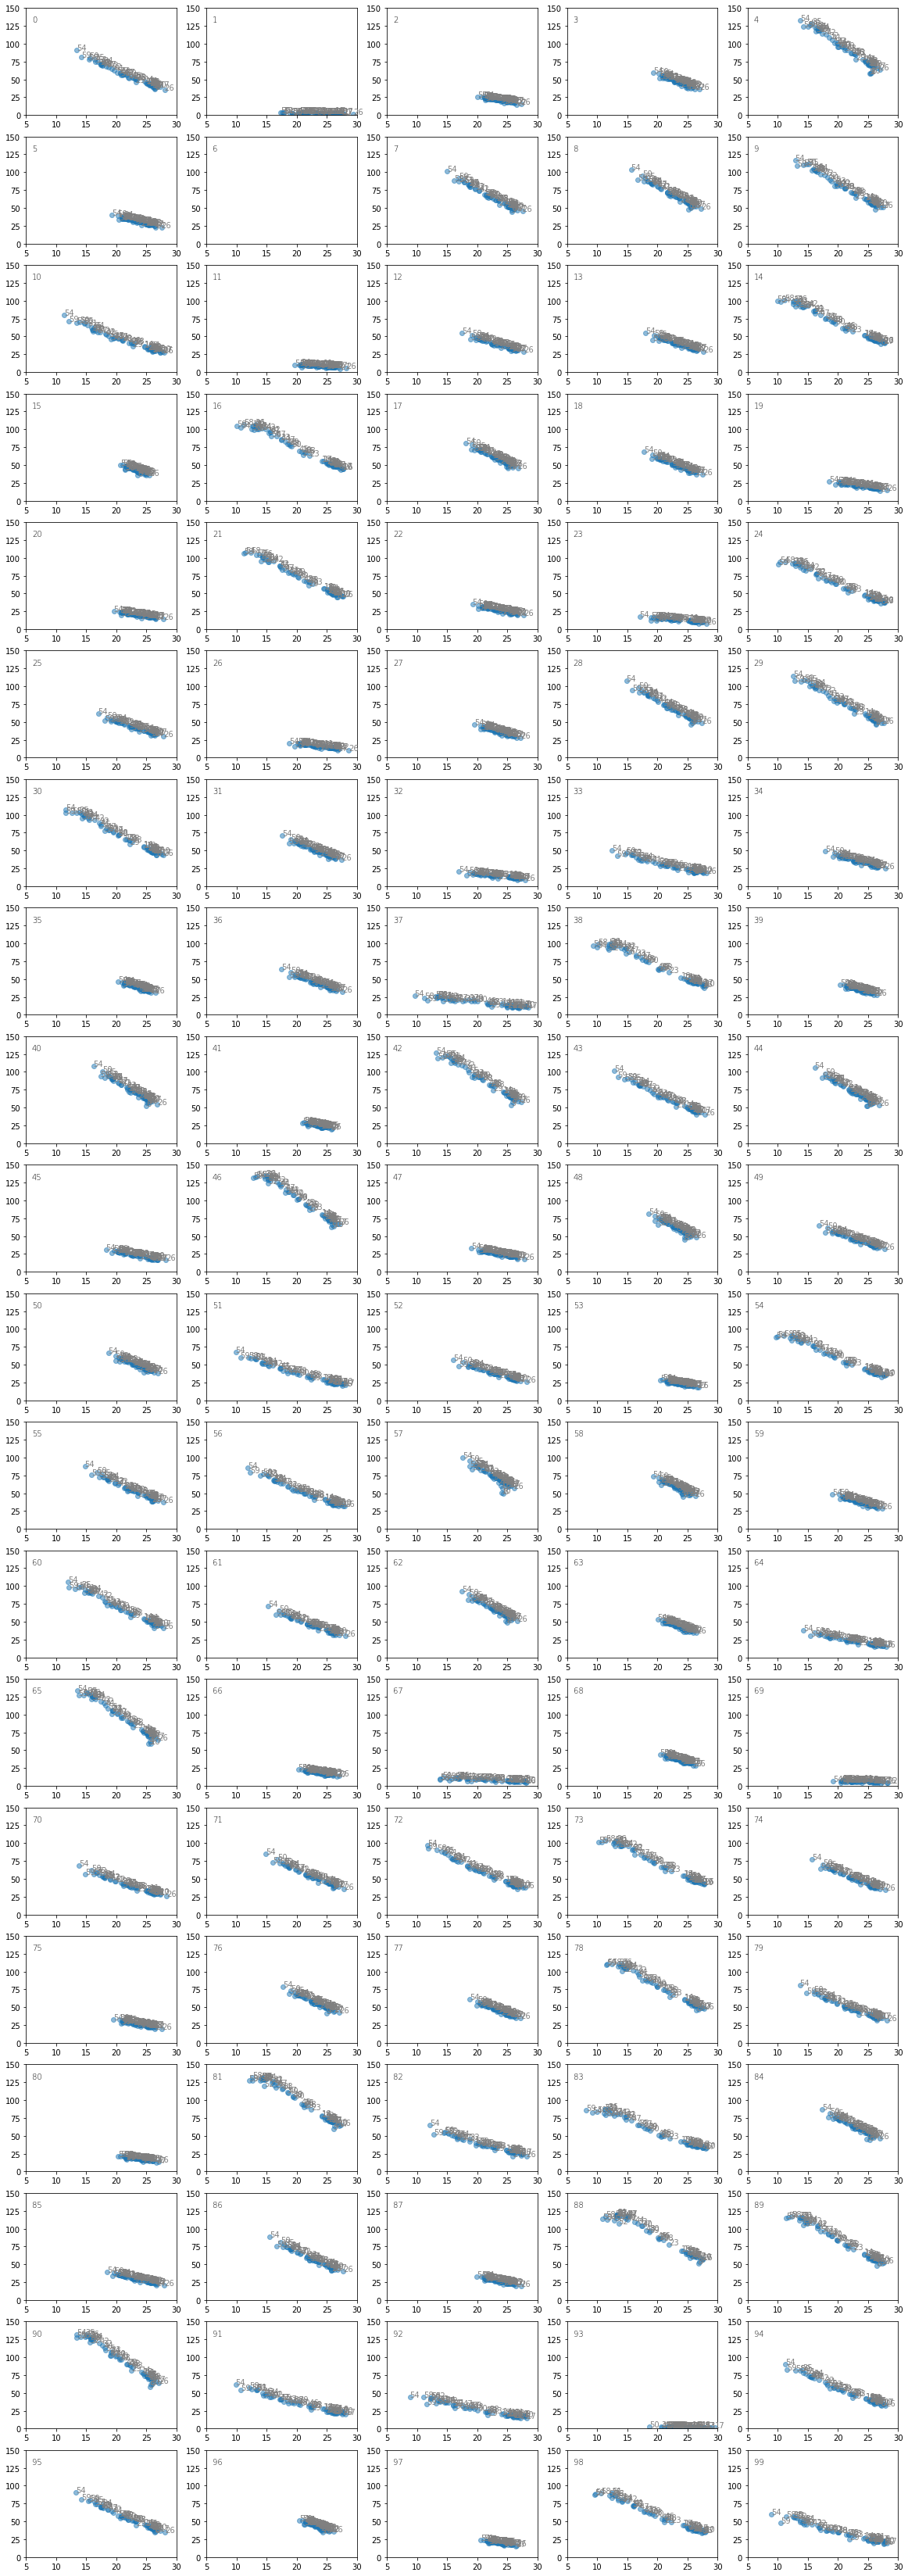

In [81]:
fig = plt.figure(figsize=(20,60))

for item in np.arange(100):
    ax = fig.add_subplot(20,5,item+1)
    ax.scatter(mx_temp[item], mx_pheno[item], alpha=0.5)
    ax.set_xlim(5,30)
    ax.set_ylim(0,150)
    ax.text(6,130,item, fontweight='light')

    for site in np.arange(60):
        if (mx_temp[item, site] != np.nan) & (mx_pheno[item, site] != np.nan):
            ax.annotate(site, (mx_temp[item, site], mx_pheno[item, site]), color='grey')